# Análisis de Cubos de Datos: Tokens y Latencias por Nodo LangGraph

Este notebook genera cubos de datos para analizar:
- Consumo de tokens por tipo de nodo
- Análisis de latencias por tipo de nodo
- Agregaciones temporales (diarias y semanales)
- Costos asociados

## Tipos de Nodos Identificados:
1. **COORDINATOR**: Nodo coordinador principal
2. **INFORMATION_AGENT**: Agente de recuperación de documentos
3. **INFORMATION_AGENT_RERANKER**: Sub-agente de reranking RankGPT
4. **INFORMATION_AGENT_GRADER**: Sub-agente evaluador de documentos
5. **HUMANIZER**: Agente humanizador de respuestas
6. **ADVISOR**: Agente asesor principal

In [1]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import json
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Funciones de Clasificación de Nodos

In [2]:
def safe_parse_json(json_string):
    """
    Parsea de forma segura strings JSON o diccionarios de Python.
    
    Args:
        json_string: String JSON, diccionario Python, o NaN
    
    Returns:
        dict: Diccionario parseado o diccionario vacío si falla
    """
    if pd.isna(json_string):
        return {}
    
    if isinstance(json_string, dict):
        return json_string
    
    if isinstance(json_string, str):
        try:
            # Intentar parsear como JSON
            return json.loads(json_string)
        except json.JSONDecodeError:
            try:
                # Intentar parsear como literal de Python
                return ast.literal_eval(json_string)
            except (ValueError, SyntaxError):
                return {}
    
    return {}


def extract_checkpoint_ns(metadata):
    """
    Extrae el valor de 'checkpoint_ns' del metadata.
    
    Args:
        metadata: Diccionario o string JSON con metadata
    
    Returns:
        str: Valor de checkpoint_ns o cadena vacía si no existe
    """
    metadata_dict = safe_parse_json(metadata)
    return metadata_dict.get('checkpoint_ns', '')


def extract_grader_flag(metadata):
    """
    Extrae el flag 'grader_evaluation' del metadata.
    
    Args:
        metadata: Diccionario o string JSON con metadata
    
    Returns:
        bool: True si grader_evaluation está en True, False en caso contrario
    """
    metadata_dict = safe_parse_json(metadata)
    return metadata_dict.get('grader_evaluation', False) is True


def extract_system_prompt(input_data):
    """
    Extrae el system prompt del campo input.
    
    Args:
        input_data: String JSON o lista con mensajes
    
    Returns:
        str: Contenido del system prompt o cadena vacía si no existe
    """
    input_parsed = safe_parse_json(input_data)
    
    if isinstance(input_parsed, list) and len(input_parsed) > 0:
        first_message = input_parsed[0]
        if isinstance(first_message, dict) and first_message.get('role') == 'system':
            return first_message.get('content', '')
    
    return ''


def classify_node_type(row):
    """
    Clasifica el tipo de nodo basándose en metadata e input.
    
    Lógica de clasificación:
    1. COORDINATOR: checkpoint_ns contiene 'coordinator'
    2. INFORMATION_AGENT_GRADER: metadata.grader_evaluation == True
    3. INFORMATION_AGENT_RERANKER: checkpoint_ns contiene 'information_agent' 
       Y system prompt inicia con 'You are RankGPT'
    4. INFORMATION_AGENT: checkpoint_ns contiene 'information_agent' 
       Y system prompt inicia con 'You are Conecta\'s document retrieval specialist'
    5. HUMANIZER: checkpoint_ns contiene 'humanizer'
    6. ADVISOR: checkpoint_ns contiene 'advisor'
    7. UNKNOWN: No coincide con ningún patrón
    
    Args:
        row: Fila del DataFrame con columnas 'metadata' e 'input'
    
    Returns:
        str: Tipo de nodo identificado
    """
    checkpoint_ns = extract_checkpoint_ns(row['metadata'])
    is_grader = extract_grader_flag(row['metadata'])
    system_prompt = extract_system_prompt(row['input'])
    
    # Orden de prioridad en la clasificación
    
    # 1. Verificar si es GRADER (tiene precedencia)
    if is_grader:
        return 'INFORMATION_AGENT_GRADER'
    
    # 2. Verificar tipos principales por checkpoint_ns
    if 'coordinator' in checkpoint_ns.lower():
        return 'COORDINATOR'
    
    if 'humanizer' in checkpoint_ns.lower():
        return 'HUMANIZER'
    
    if 'advisor' in checkpoint_ns.lower():
        return 'ADVISOR'
    
    # 3. Para information_agent, discriminar por system prompt
    if 'information_agent' in checkpoint_ns.lower():
        if system_prompt.startswith('You are RankGPT'):
            return 'INFORMATION_AGENT_RERANKER'
        elif system_prompt.startswith("You are Conecta\'s document retrieval specialist") or \
             system_prompt.startswith("You are Conecta's document retrieval specialist"):
            return 'INFORMATION_AGENT'
        else:
            # Si tiene information_agent pero no coincide el prompt, asumir INFORMATION_AGENT
            return 'INFORMATION_AGENT'
    
    return 'UNKNOWN'


print("✅ Funciones de clasificación definidas")

✅ Funciones de clasificación definidas


## 2. Carga y Preparación de Datos

In [3]:
# CONFIGURACIÓN: Actualiza esta ruta con tu archivo CSV
CSV_FILE_PATH = 'data/langfuse_generations_CONSOLIDADO_20251113_125037.csv'  # Cambia esto por tu ruta

# Cargar datos
print(f"📂 Cargando datos desde: {CSV_FILE_PATH}")
df = pd.read_csv(CSV_FILE_PATH)

print(f"\n📊 Datos cargados: {len(df)} registros")
print(f"📅 Columnas disponibles: {len(df.columns)}")

# Mostrar primeras filas
df.head(2)

📂 Cargando datos desde: data/langfuse_generations_CONSOLIDADO_20251113_125037.csv

📊 Datos cargados: 196236 registros
📅 Columnas disponibles: 36


,id,traceId,type,name,startTime,endTime,model,modelParameters,input,metadata,output,usage,level,parentObservationId,latency,createdAt,updatedAt,promptTokens,totalTokens,completionTokens,projectId,completionStartTime,version,statusMessage,promptId,promptName,promptVersion,modelId,inputPrice,outputPrice,totalPrice,calculatedInputCost,calculatedOutputCost,calculatedTotalCost,timeToFirstToken,unit
0,9deb35e2-910d-45d9-bbaa-64ca9635a2ad,f121a0b9-eb3b-49d3-a36d-68930752c097,GENERATION,AzureChatOpenAI,2025-10-12 23:23:33.819000+00:00,2025-10-12 23:23:39.614000+00:00,gpt-4.1-mini-2025-04-14,"{'max_tokens': 8192, 'temperature': '0.0'}","[{'role': 'system', 'content': '<ROLE>\nYou ar...","{'tags': ['seq:step:2', 'conecta', 'main_workf...","{'role': 'assistant', 'content': '{\n ""adviso...","{'input': 509, 'output': 450, 'total': 3135, '...",DEFAULT,d1f3c6f3-9c23-429b-9646-ed028fff3f8b,5.795,2025-10-12T23:23:34.847Z,2025-10-12T23:23:39.778Z,509,3135,450,cmglidbeg0008b5zo6fpcsxal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,da8f2c22-b14d-4ab0-b1b5-a22c573f3b7b,f121a0b9-eb3b-49d3-a36d-68930752c097,GENERATION,AzureChatOpenAI,2025-10-12 23:23:29.777000+00:00,2025-10-12 23:23:33.795000+00:00,gpt-4.1-mini-2025-04-14,"{'max_tokens': 8192, 'temperature': '0.0'}","[{'role': 'system', 'content': 'You are Conect...","{'tags': ['seq:step:2', 'conecta', 'main_workf...","{'role': 'assistant', 'content': '## Advisor Q...","{'input': 1088, 'output': 440, 'total': 4216, ...",DEFAULT,3a29a540-5c37-4980-b380-afc3eac081fb,4.018,2025-10-12T23:23:30.955Z,2025-10-12T23:23:34.047Z,1088,4216,440,cmglidbeg0008b5zo6fpcsxal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Aplicar clasificación de nodos
print("🔍 Clasificando tipos de nodos...")
df['node_type'] = df.apply(classify_node_type, axis=1)

# Convertir timestamps a datetime
print("📅 Procesando timestamps...")
df['startTime'] = pd.to_datetime(df['startTime'], errors='coerce')
df['endTime'] = pd.to_datetime(df['endTime'], errors='coerce')
df['createdAt'] = pd.to_datetime(df['createdAt'], errors='coerce')

# Crear columnas de fecha para agregaciones temporales
df['date'] = df['startTime'].dt.date
df['week'] = df['startTime'].dt.to_period('W').astype(str)
df['hour'] = df['startTime'].dt.hour

# Asegurar tipos numéricos para métricas
numeric_cols = ['promptTokens', 'completionTokens', 'totalTokens', 'latency', 
                'timeToFirstToken', 'calculatedInputCost', 'calculatedOutputCost', 
                'calculatedTotalCost']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("✅ Datos preparados correctamente")

# Resumen de clasificación
print("\n📊 Distribución de tipos de nodos:")
print(df['node_type'].value_counts())

🔍 Clasificando tipos de nodos...
📅 Procesando timestamps...
✅ Datos preparados correctamente

📊 Distribución de tipos de nodos:
node_type
INFORMATION_AGENT_GRADER      62211
INFORMATION_AGENT             41428
COORDINATOR                   37181
INFORMATION_AGENT_RERANKER    20737
HUMANIZER                     20684
ADVISOR                       10684
UNKNOWN                        3311
Name: count, dtype: int64


## 3. Generación de Cubos de Datos

### 3.1 Cubo de Consumo de Tokens

In [5]:
def create_token_consumption_cube(df):
    """
    Genera cubo de datos con métricas de consumo de tokens por tipo de nodo.
    
    Métricas incluidas:
    - Total de llamadas
    - Totales de tokens (input, output, total)
    - Promedios de tokens
    - Costos totales y promedios
    
    Args:
        df: DataFrame con datos procesados
    
    Returns:
        DataFrame: Cubo agregado por tipo de nodo
    """
    token_cube = df.groupby('node_type').agg({
        'id': 'count',  # Total de llamadas
        'promptTokens': ['sum', 'mean', 'median'],
        'completionTokens': ['sum', 'mean', 'median'],
        'totalTokens': ['sum', 'mean', 'median'],
        'calculatedInputCost': ['sum', 'mean'],
        'calculatedOutputCost': ['sum', 'mean'],
        'calculatedTotalCost': ['sum', 'mean']
    }).round(2)
    
    # Renombrar columnas para claridad
    token_cube.columns = ['_'.join(col).strip() for col in token_cube.columns.values]
    token_cube.rename(columns={'id_count': 'total_calls'}, inplace=True)
    
    return token_cube.reset_index()


# Generar cubo de tokens
token_cube = create_token_consumption_cube(df)
print("✅ Cubo de consumo de tokens generado\n")
print("📊 Cubo de Tokens por Tipo de Nodo:")
token_cube

✅ Cubo de consumo de tokens generado

📊 Cubo de Tokens por Tipo de Nodo:


,node_type,total_calls,promptTokens_sum,promptTokens_mean,promptTokens_median,completionTokens_sum,completionTokens_mean,completionTokens_median,totalTokens_sum,totalTokens_mean,totalTokens_median,calculatedInputCost_sum,calculatedInputCost_mean,calculatedOutputCost_sum,calculatedOutputCost_mean,calculatedTotalCost_sum,calculatedTotalCost_mean
0,ADVISOR,10684,18302740,1713.10,1667.0,259585,24.30,22.0,18588053,1739.80,1696.5,0.48,0.0,0.03,0.0,0.50,0.00
1,COORDINATOR,37181,58684998,1578.36,1373.0,1069936,28.78,6.0,113938358,3064.42,3067.0,1.51,0.0,0.11,0.0,1.61,0.00
2,HUMANIZER,20684,20070982,970.36,556.0,5760843,278.52,273.0,60998161,2949.05,2911.0,0.49,0.0,0.66,0.0,1.15,0.00
3,INFORMATION_AGENT,41428,44438576,1072.67,466.5,8009376,193.33,42.0,143828048,3471.76,2908.0,1.44,0.0,0.90,0.0,2.34,0.00
4,INFORMATION_AGENT_GRADER,62211,86015546,1382.64,1297.0,124073,1.99,2.0,87036003,1399.05,1304.0,11.74,0.0,0.07,0.0,11.81,0.00
5,INFORMATION_AGENT_RERANKER,20737,40908175,1972.71,1836.0,3220350,155.29,189.0,45555085,2196.80,2035.0,5.64,0.0,1.73,0.0,7.36,0.01
6,UNKNOWN,3311,5179700,1564.39,1216.0,800057,241.64,2.0,6498029,1962.56,1419.0,0.07,0.0,0.04,0.0,0.11,0.00


### 3.2 Cubo de Análisis de Latencias

In [6]:
def create_latency_analysis_cube(df):
    """
    Genera cubo de datos con análisis de latencias por tipo de nodo.
    
    Métricas incluidas:
    - Estadísticas de latency (mean, median, min, max, p95, p99)
    - Estadísticas de timeToFirstToken
    
    Args:
        df: DataFrame con datos procesados
    
    Returns:
        DataFrame: Cubo agregado por tipo de nodo
    """
    latency_cube = df.groupby('node_type').agg({
        'latency': [
            'mean', 'median', 'min', 'max', 'std',
            lambda x: x.quantile(0.95),  # P95
            lambda x: x.quantile(0.99)   # P99
        ],
        'timeToFirstToken': [
            'mean', 'median', 'min', 'max',
            lambda x: x.quantile(0.95),  # P95
            lambda x: x.quantile(0.99)   # P99
        ]
    }).round(3)
    
    # Renombrar columnas
    new_cols = []
    for col in latency_cube.columns:
        metric, stat = col
        if 'lambda' in str(stat):
            # Detectar si es P95 o P99 por posición
            if 'latency' in metric:
                stat_name = 'p95' if new_cols.count(metric + '_p95') == 0 and new_cols.count(metric + '_p99') == 0 else 'p99'
            else:
                stat_name = 'p95' if new_cols.count(metric + '_p95') == 0 and new_cols.count(metric + '_p99') == 0 else 'p99'
            new_cols.append(f"{metric}_{stat_name}")
        else:
            new_cols.append(f"{metric}_{stat}")
    
    latency_cube.columns = new_cols
    
    return latency_cube.reset_index()


# Generar cubo de latencias
latency_cube = create_latency_analysis_cube(df)
print("✅ Cubo de análisis de latencias generado\n")
print("📊 Cubo de Latencias por Tipo de Nodo:")
latency_cube

✅ Cubo de análisis de latencias generado

📊 Cubo de Latencias por Tipo de Nodo:


,node_type,latency_mean,latency_median,latency_min,latency_max,latency_std,latency_p95,latency_p99,timeToFirstToken_mean,timeToFirstToken_median,timeToFirstToken_min,timeToFirstToken_max,timeToFirstToken_p95,timeToFirstToken_p99
0,ADVISOR,1.117,0.757,0.276,101.720,2.270,2.517,6.822,NaN,NaN,NaN,NaN,NaN,NaN
1,COORDINATOR,1.194,0.778,0.067,73.274,1.334,3.179,6.010,NaN,NaN,NaN,NaN,NaN,NaN
2,HUMANIZER,6.039,4.694,0.667,105.642,5.354,15.728,26.925,NaN,NaN,NaN,NaN,NaN,NaN
3,INFORMATION_AGENT,4.828,1.619,0.074,480.496,7.671,18.526,34.548,NaN,NaN,NaN,NaN,NaN,NaN
4,INFORMATION_AGENT_GRADER,0.408,0.361,0.058,137.814,1.070,0.545,0.786,NaN,NaN,NaN,NaN,NaN,NaN
5,INFORMATION_AGENT_RERANKER,1.889,2.060,0.084,96.598,1.252,3.351,4.532,NaN,NaN,NaN,NaN,NaN,NaN
6,UNKNOWN,5.454,0.425,0.058,125.889,14.102,30.445,72.706,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3 Cubo de Agregación Diaria

In [7]:
def create_daily_aggregation_cube(df):
    """
    Genera cubo de datos con agregaciones diarias por tipo de nodo.
    
    Incluye segmentación de tokens de entrada y salida.
    
    Args:
        df: DataFrame con datos procesados
    
    Returns:
        DataFrame: Cubo agregado por fecha y tipo de nodo
    """
    daily_cube = df.groupby(['date', 'node_type']).agg({
        'id': 'count',
        'promptTokens': ['sum', 'mean'],
        'completionTokens': ['sum', 'mean'],
        'totalTokens': ['sum', 'mean'],
        'latency': ['mean', 'median'],
        'calculatedTotalCost': ['sum', 'mean']
    }).round(2)
    
    # Renombrar columnas
    daily_cube.columns = ['_'.join(col).strip() for col in daily_cube.columns.values]
    daily_cube.rename(columns={'id_count': 'total_calls'}, inplace=True)
    
    return daily_cube.reset_index()


# Generar cubo diario
daily_cube = create_daily_aggregation_cube(df)
print("✅ Cubo de agregación diaria generado\n")
print("📊 Cubo Diario (primeras 10 filas):")
daily_cube.head(10)

✅ Cubo de agregación diaria generado

📊 Cubo Diario (primeras 10 filas):


,date,node_type,total_calls,promptTokens_sum,promptTokens_mean,completionTokens_sum,completionTokens_mean,totalTokens_sum,totalTokens_mean,latency_mean,latency_median,calculatedTotalCost_sum,calculatedTotalCost_mean
0,2025-10-11,ADVISOR,129,220292,1707.69,3179,24.64,224495,1740.27,0.58,0.50,0.0,NaN
1,2025-10-11,COORDINATOR,456,704013,1543.89,9398,20.61,1417667,3108.92,0.57,0.47,0.0,NaN
2,2025-10-11,HUMANIZER,329,251614,764.78,86963,264.33,964497,2931.60,2.54,2.38,0.0,NaN
3,2025-10-11,INFORMATION_AGENT,660,541474,820.42,120667,182.83,2281725,3457.16,2.00,0.74,0.0,NaN
4,2025-10-11,INFORMATION_AGENT_GRADER,993,1346594,1356.09,1986,2.00,1377636,1387.35,0.32,0.32,0.0,NaN
5,2025-10-11,INFORMATION_AGENT_RERANKER,330,612476,1855.99,54996,166.65,714192,2164.22,1.65,1.86,0.0,NaN
6,2025-10-11,UNKNOWN,18,12862,714.56,887,49.28,13749,763.83,0.70,0.31,0.0,NaN
7,2025-10-12,ADVISOR,34,54007,1588.44,643,18.91,54650,1607.35,0.50,0.50,0.0,NaN
8,2025-10-12,COORDINATOR,130,247985,1907.58,2806,21.58,397351,3056.55,0.62,0.46,0.0,NaN
9,2025-10-12,HUMANIZER,89,114834,1290.27,21689,243.70,254283,2857.11,2.56,2.51,0.0,NaN


### 3.4 Cubo de Agregación Semanal

In [8]:
def create_weekly_aggregation_cube(df):
    """
    Genera cubo de datos con agregaciones semanales por tipo de nodo.
    
    Incluye segmentación de tokens de entrada y salida.
    
    Args:
        df: DataFrame con datos procesados
    
    Returns:
        DataFrame: Cubo agregado por semana y tipo de nodo
    """
    weekly_cube = df.groupby(['week', 'node_type']).agg({
        'id': 'count',
        'promptTokens': ['sum', 'mean'],
        'completionTokens': ['sum', 'mean'],
        'totalTokens': ['sum', 'mean'],
        'latency': ['mean', 'median'],
        'calculatedTotalCost': ['sum', 'mean']
    }).round(2)
    
    # Renombrar columnas
    weekly_cube.columns = ['_'.join(col).strip() for col in weekly_cube.columns.values]
    weekly_cube.rename(columns={'id_count': 'total_calls'}, inplace=True)
    
    return weekly_cube.reset_index()


# Generar cubo semanal
weekly_cube = create_weekly_aggregation_cube(df)
print("✅ Cubo de agregación semanal generado\n")
print("📊 Cubo Semanal:")
weekly_cube.head(10)

✅ Cubo de agregación semanal generado

📊 Cubo Semanal:


,week,node_type,total_calls,promptTokens_sum,promptTokens_mean,completionTokens_sum,completionTokens_mean,totalTokens_sum,totalTokens_mean,latency_mean,latency_median,calculatedTotalCost_sum,calculatedTotalCost_mean
0,2025-10-06/2025-10-12,ADVISOR,163,274299,1682.82,3822,23.45,279145,1712.55,0.56,0.50,0.0,NaN
1,2025-10-06/2025-10-12,COORDINATOR,586,951998,1624.57,12204,20.83,1815018,3097.30,0.58,0.47,0.0,NaN
2,2025-10-06/2025-10-12,HUMANIZER,418,366448,876.67,108652,259.93,1218780,2915.74,2.54,2.40,0.0,NaN
3,2025-10-06/2025-10-12,INFORMATION_AGENT,839,733324,874.05,151557,180.64,2885649,3439.39,2.00,0.74,0.0,NaN
4,2025-10-06/2025-10-12,INFORMATION_AGENT_GRADER,1263,1719301,1361.28,2526,2.00,1754595,1389.23,0.32,0.32,0.0,NaN
5,2025-10-06/2025-10-12,INFORMATION_AGENT_RERANKER,420,791369,1884.21,68914,164.08,912635,2172.94,1.62,1.82,0.0,NaN
6,2025-10-06/2025-10-12,UNKNOWN,18,12862,714.56,887,49.28,13749,763.83,0.70,0.31,0.0,NaN
7,2025-10-13/2025-10-19,ADVISOR,2521,4309916,1709.61,59389,23.56,4370585,1733.67,1.00,0.80,0.0,NaN
8,2025-10-13/2025-10-19,COORDINATOR,8543,13740230,1608.36,245071,28.69,26474517,3098.97,1.16,0.77,0.0,NaN
9,2025-10-13/2025-10-19,HUMANIZER,4842,4897754,1011.51,1315366,271.66,14232960,2939.48,6.49,5.22,0.0,NaN


### 3.5 Cubo de Totales y Promedios Generales

In [9]:
def create_overall_summary_cube(df):
    """
    Genera cubo resumen con totales y promedios generales por tipo de nodo.
    
    Incluye todas las métricas clave consolidadas.
    
    Args:
        df: DataFrame con datos procesados
    
    Returns:
        DataFrame: Cubo resumen por tipo de nodo
    """
    summary_cube = df.groupby('node_type').agg({
        'id': 'count',
        'promptTokens': 'sum',
        'completionTokens': 'sum',
        'totalTokens': ['sum', 'mean'],
        'latency': ['mean', 'median', lambda x: x.quantile(0.95)],
        'timeToFirstToken': 'mean',
        'calculatedTotalCost': ['sum', 'mean']
    }).round(2)
    
    # Renombrar columnas
    new_cols = []
    for col in summary_cube.columns:
        metric, stat = col
        if 'lambda' in str(stat):
            new_cols.append(f"{metric}_p95")
        else:
            new_cols.append(f"{metric}_{stat}")
    
    summary_cube.columns = new_cols
    summary_cube.rename(columns={'id_count': 'total_calls'}, inplace=True)
    
    return summary_cube.reset_index()


# Generar cubo resumen
summary_cube = create_overall_summary_cube(df)
print("✅ Cubo resumen general generado\n")
print("📊 Cubo Resumen Total y Promedios:")
summary_cube

✅ Cubo resumen general generado

📊 Cubo Resumen Total y Promedios:


,node_type,total_calls,promptTokens_sum,completionTokens_sum,totalTokens_sum,totalTokens_mean,latency_mean,latency_median,latency_p95,timeToFirstToken_mean,calculatedTotalCost_sum,calculatedTotalCost_mean
0,ADVISOR,10684,18302740,259585,18588053,1739.80,1.12,0.76,2.52,NaN,0.50,0.00
1,COORDINATOR,37181,58684998,1069936,113938358,3064.42,1.19,0.78,3.18,NaN,1.61,0.00
2,HUMANIZER,20684,20070982,5760843,60998161,2949.05,6.04,4.69,15.73,NaN,1.15,0.00
3,INFORMATION_AGENT,41428,44438576,8009376,143828048,3471.76,4.83,1.62,18.53,NaN,2.34,0.00
4,INFORMATION_AGENT_GRADER,62211,86015546,124073,87036003,1399.05,0.41,0.36,0.55,NaN,11.81,0.00
5,INFORMATION_AGENT_RERANKER,20737,40908175,3220350,45555085,2196.80,1.89,2.06,3.35,NaN,7.36,0.01
6,UNKNOWN,3311,5179700,800057,6498029,1962.56,5.45,0.42,30.44,NaN,0.11,0.00


In [10]:
def export_unknown_sample(df, sample_size=100, output_file='data/unknown_generations_sample.csv'):
    """
    Exporta una muestra de registros UNKNOWN para análisis.
    
    Args:
        df: DataFrame con datos procesados
        sample_size: Número de registros a exportar (default: 100)
        output_file: Ruta del archivo de salida
    
    Returns:
        DataFrame: Muestra de registros UNKNOWN exportados
    """
    import os
    
    # Filtrar registros UNKNOWN
    unknown_df = df[df['node_type'] == 'UNKNOWN'].copy()
    total_unknown = len(unknown_df)
    
    if total_unknown == 0:
        print("⚠️ No se encontraron registros UNKNOWN en el dataset")
        return pd.DataFrame()
    
    # Tomar muestra
    if total_unknown <= sample_size:
        sample_df = unknown_df
        print(f"📊 Se encontraron {total_unknown} registros UNKNOWN (menos que el límite de {sample_size})")
        print(f"   Exportando todos los registros...")
    else:
        sample_df = unknown_df.sample(n=sample_size, random_state=42)
        print(f"📊 Se encontraron {total_unknown} registros UNKNOWN")
        print(f"   Exportando muestra de {sample_size} registros...")
    
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Exportar a CSV
    sample_df.to_csv(output_file, index=False)
    print(f"✅ Muestra exportada exitosamente a: {output_file}\n")
    
    # Mostrar estadísticas básicas
    print(f"📋 Estadísticas de la muestra UNKNOWN:")
    print(f"  • Total de registros: {len(sample_df)}")
    if 'model' in sample_df.columns:
        print(f"  • Modelos encontrados: {sample_df['model'].nunique()}")
        print(f"  • Distribución por modelo:")
        for model, count in sample_df['model'].value_counts().head(5).items():
            print(f"    - {model}: {count} registros")
    
    return sample_df


# Exportar muestra de UNKNOWN
unknown_sample = export_unknown_sample(df, sample_size=100)

# Mostrar primeras filas de la muestra
if not unknown_sample.empty:
    print("\n📊 Primeras 3 filas de la muestra UNKNOWN:")
    display(unknown_sample[['id', 'name', 'model', 'input', 'metadata']].head(3))

📊 Se encontraron 3311 registros UNKNOWN
   Exportando muestra de 100 registros...
✅ Muestra exportada exitosamente a: data/unknown_generations_sample.csv

📋 Estadísticas de la muestra UNKNOWN:
  • Total de registros: 100
  • Modelos encontrados: 2
  • Distribución por modelo:
    - gpt-4.1-mini-2025-04-14: 98 registros
    - gpt-4.1-mini: 2 registros

📊 Primeras 3 filas de la muestra UNKNOWN:


,id,name,model,input,metadata
6546,7eed586b-95d0-4c32-8815-fc3850003931,AzureChatOpenAI,gpt-4.1-mini-2025-04-14,"[{'role': 'system', 'content': '### CONTEXT AN...","{'tags': ['seq:step:2'], 'ls_provider': 'azure..."
37149,ca88f866-f06c-4b12-9865-075c117dc33a,AzureChatOpenAI,gpt-4.1-mini-2025-04-14,"[{'role': 'system', 'content': ""You are a grad...","{'tags': ['seq:step:2', 'retrieval_grader'], '..."
63530,8d88703a-cc10-4570-aa7d-f80c989ace16,AzureChatOpenAI,gpt-4.1-mini,"[{'role': 'system', 'content': '### Objetivo\n...","{'tags': ['seq:step:2'], 'ls_provider': 'azure..."


### 3.6 Exportar Muestra de Registros UNKNOWN

## 4. Visualizaciones

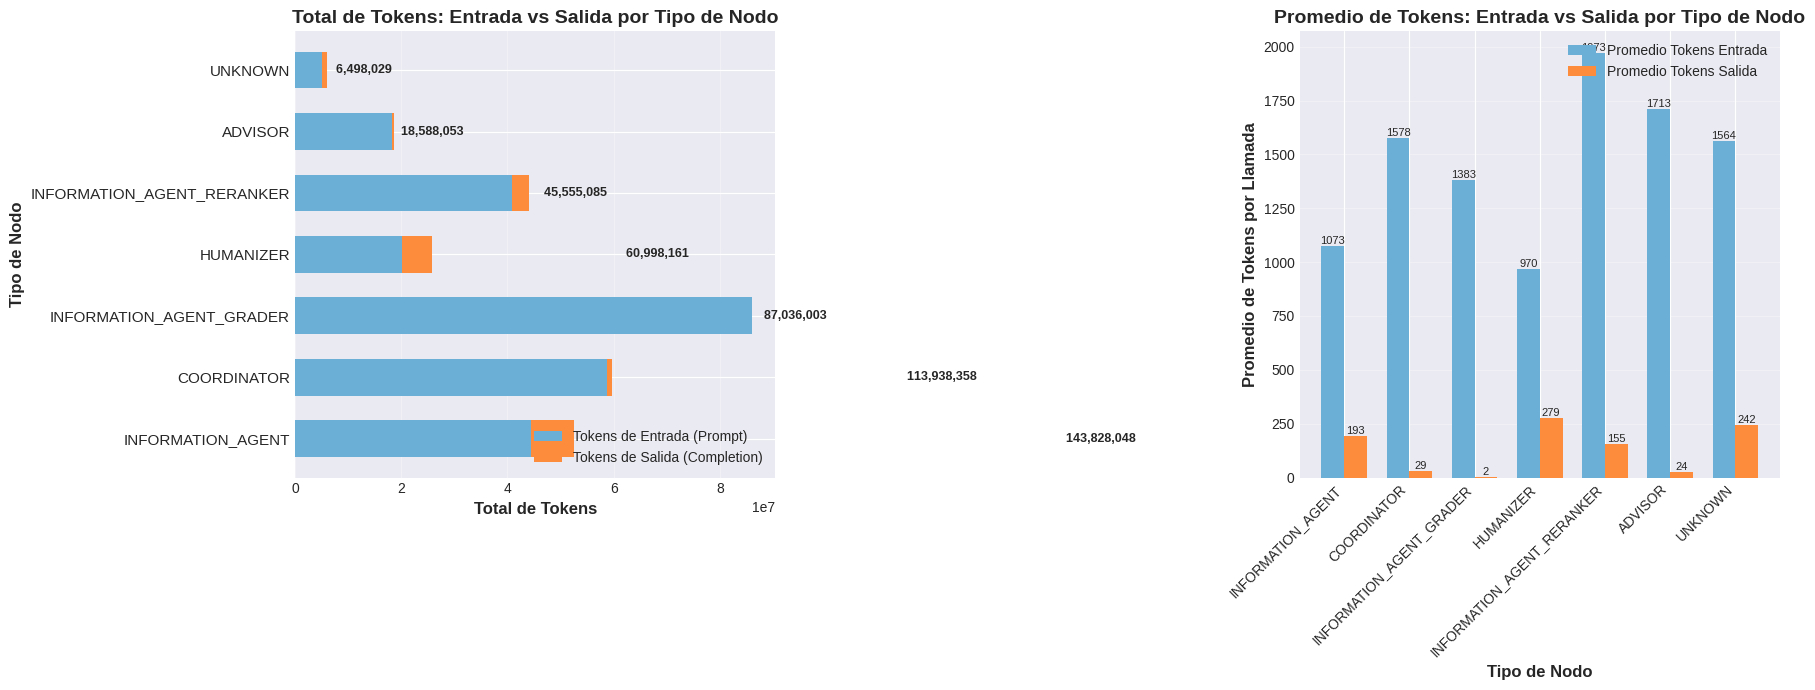

In [11]:
def plot_tokens_input_output_comparison(token_cube):
    """
    Visualiza la comparación de tokens de entrada vs salida mediante barras apiladas.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Preparar datos ordenados
    token_data = token_cube.sort_values('totalTokens_sum', ascending=False)
    
    # Gráfico 1: Barras apiladas - Totales
    ax1 = axes[0]
    x = np.arange(len(token_data))
    width = 0.6
    
    bars1 = ax1.barh(x, token_data['promptTokens_sum'], width, 
                     label='Tokens de Entrada (Prompt)', color='#6baed6')
    bars2 = ax1.barh(x, token_data['completionTokens_sum'], width, 
                     left=token_data['promptTokens_sum'],
                     label='Tokens de Salida (Completion)', color='#fd8d3c')
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(token_data['node_type'], fontsize=11)
    ax1.set_xlabel('Total de Tokens', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Tipo de Nodo', fontsize=12, fontweight='bold')
    ax1.set_title('Total de Tokens: Entrada vs Salida por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(axis='x', alpha=0.3)
    
    # Añadir valores totales al final de cada barra
    for i, (idx, row) in enumerate(token_data.iterrows()):
        total = row['totalTokens_sum']
        ax1.text(total, i, f'  {int(total):,}', va='center', fontsize=9, fontweight='bold')
    
    # Gráfico 2: Barras agrupadas - Promedios
    ax2 = axes[1]
    x2 = np.arange(len(token_data))
    width2 = 0.35
    
    bars1 = ax2.bar(x2 - width2/2, token_data['promptTokens_mean'], width2,
                    label='Promedio Tokens Entrada', color='#6baed6')
    bars2 = ax2.bar(x2 + width2/2, token_data['completionTokens_mean'], width2,
                    label='Promedio Tokens Salida', color='#fd8d3c')
    
    ax2.set_xticks(x2)
    ax2.set_xticklabels(token_data['node_type'], rotation=45, ha='right', fontsize=10)
    ax2.set_ylabel('Promedio de Tokens por Llamada', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Tipo de Nodo', fontsize=12, fontweight='bold')
    ax2.set_title('Promedio de Tokens: Entrada vs Salida por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


plot_tokens_input_output_comparison(token_cube)

### 4.1b Comparación de Tokens de Entrada vs Salida por Nodo

### 4.1 Distribución de Tokens por Tipo de Nodo

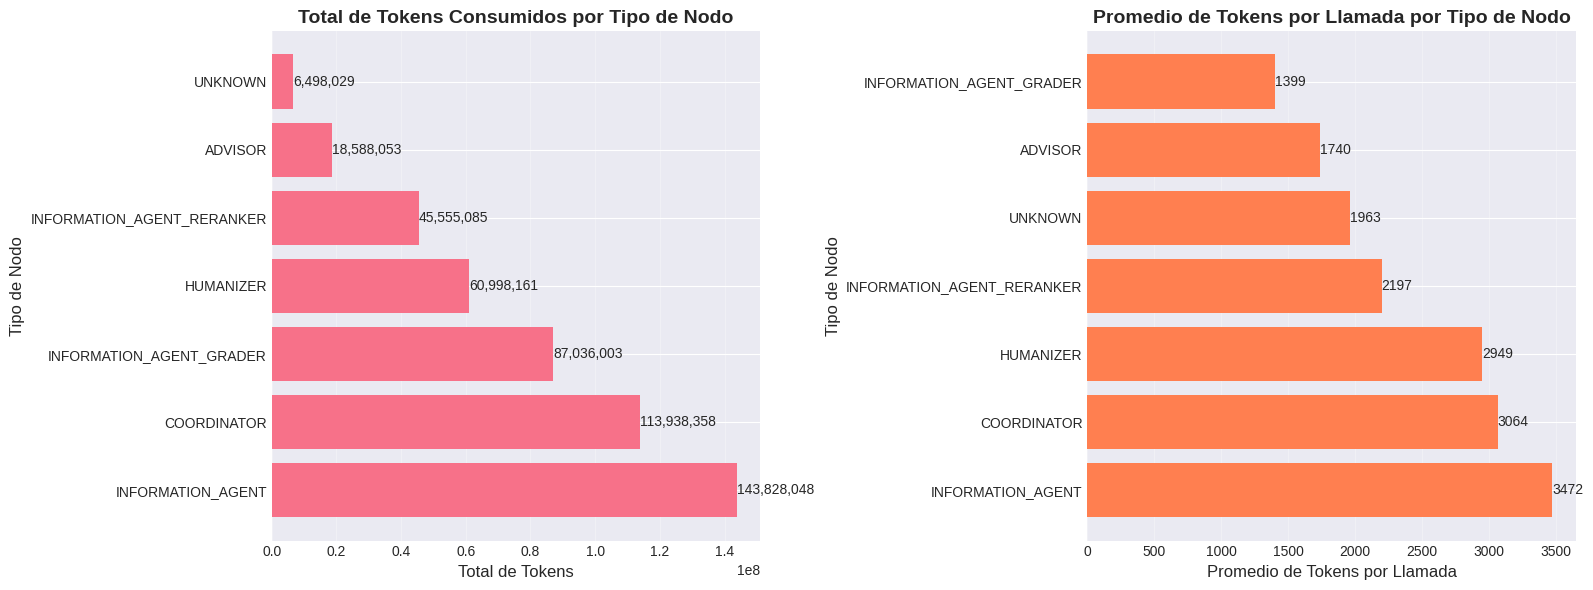

In [12]:
def plot_token_distribution(token_cube):
    """
    Visualiza la distribución de tokens totales por tipo de nodo.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Tokens totales por nodo
    ax1 = axes[0]
    token_data = token_cube.sort_values('totalTokens_sum', ascending=False)
    bars1 = ax1.barh(token_data['node_type'], token_data['totalTokens_sum'])
    ax1.set_xlabel('Total de Tokens', fontsize=12)
    ax1.set_ylabel('Tipo de Nodo', fontsize=12)
    ax1.set_title('Total de Tokens Consumidos por Tipo de Nodo', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=10)
    
    # Gráfico 2: Promedio de tokens por llamada
    ax2 = axes[1]
    avg_data = token_cube.sort_values('totalTokens_mean', ascending=False)
    bars2 = ax2.barh(avg_data['node_type'], avg_data['totalTokens_mean'], color='coral')
    ax2.set_xlabel('Promedio de Tokens por Llamada', fontsize=12)
    ax2.set_ylabel('Tipo de Nodo', fontsize=12)
    ax2.set_title('Promedio de Tokens por Llamada por Tipo de Nodo', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for bar in bars2:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.0f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


plot_token_distribution(token_cube)

### 4.2 Análisis de Costos por Tipo de Nodo

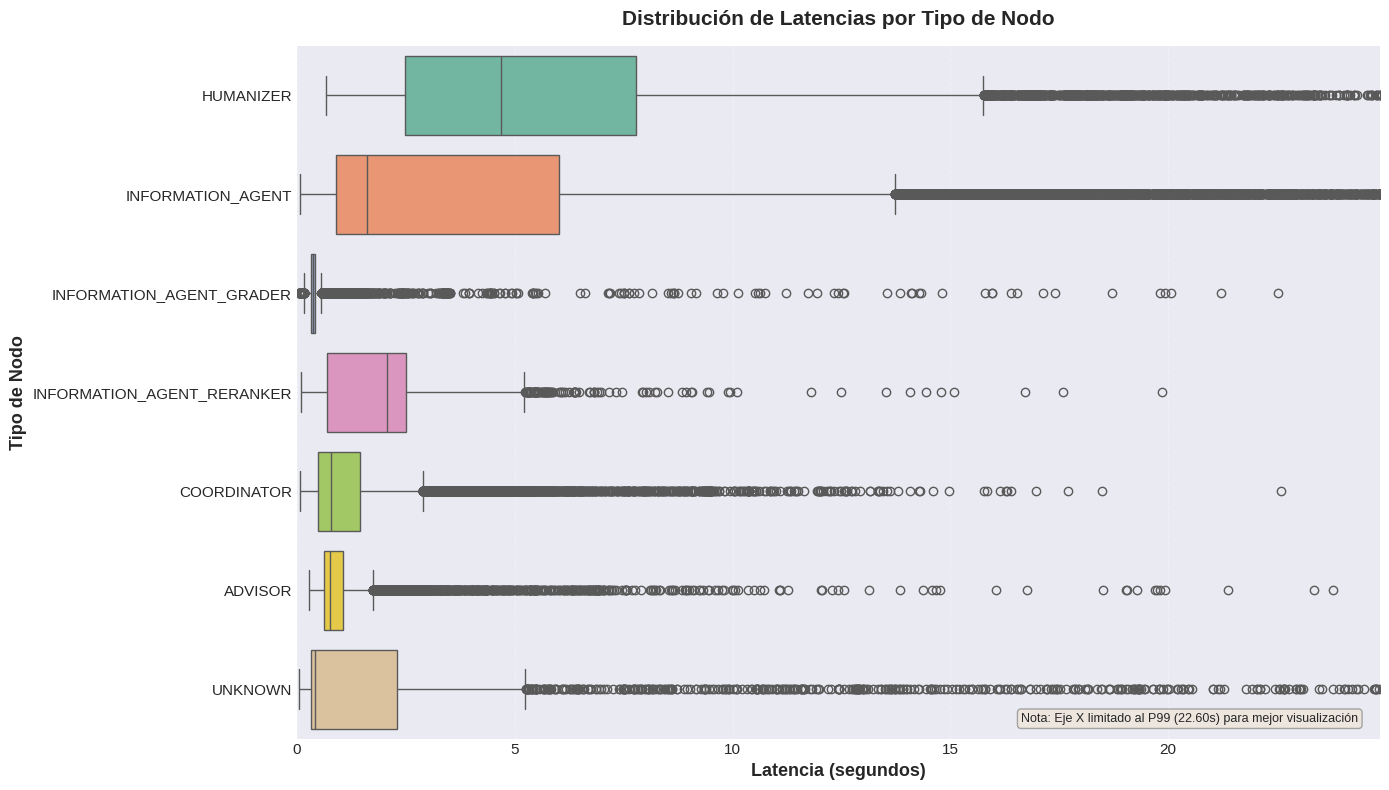

In [13]:
def plot_latency_distribution(df):
    """
    Visualiza la distribución de latencias mediante boxplot mejorado.
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Filtrar datos y calcular percentil 99 para límite del eje
    df_clean = df[df['latency'].notna()].copy()
    p99_latency = df_clean['latency'].quantile(0.99)
    
    # Crear boxplot horizontal para mejor legibilidad
    sns.boxplot(data=df_clean, y='node_type', x='latency', ax=ax, palette='Set2', orient='h')
    
    # Configurar ejes
    ax.set_ylabel('Tipo de Nodo', fontsize=13, fontweight='bold')
    ax.set_xlabel('Latencia (segundos)', fontsize=13, fontweight='bold')
    ax.set_title('Distribución de Latencias por Tipo de Nodo', fontsize=15, fontweight='bold', pad=15)
    
    # Limitar eje X al percentil 99 para mejor visualización (eliminando outliers extremos)
    ax.set_xlim(0, p99_latency * 1.1)
    
    # Añadir grid para mejor lectura
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Aumentar tamaño de las etiquetas del eje y
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=11)
    
    # Añadir nota sobre el límite
    ax.text(0.98, 0.02, f'Nota: Eje X limitado al P99 ({p99_latency:.2f}s) para mejor visualización', 
            transform=ax.transAxes, fontsize=9, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()


plot_latency_distribution(df)

### 4.3 Distribución de Latencias por Tipo de Nodo

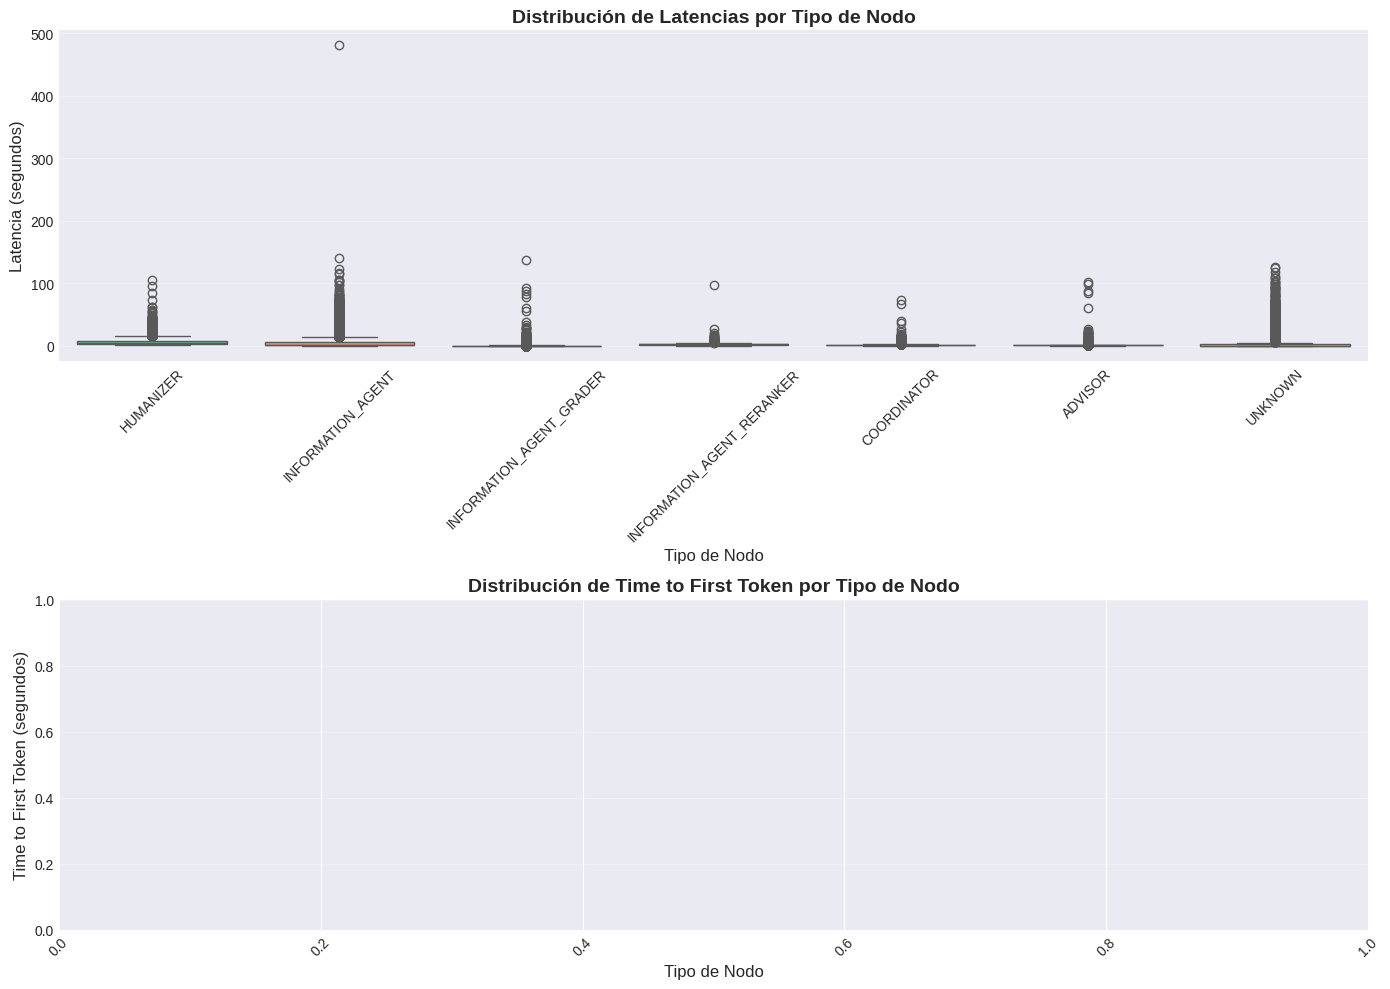

In [14]:
def plot_latency_distribution(df):
    """
    Visualiza la distribución de latencias mediante boxplots.
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Gráfico 1: Boxplot de latency
    ax1 = axes[0]
    df_clean = df[df['latency'].notna()]
    sns.boxplot(data=df_clean, x='node_type', y='latency', ax=ax1, palette='Set2')
    ax1.set_xlabel('Tipo de Nodo', fontsize=12)
    ax1.set_ylabel('Latencia (segundos)', fontsize=12)
    ax1.set_title('Distribución de Latencias por Tipo de Nodo', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Gráfico 2: Boxplot de timeToFirstToken
    ax2 = axes[1]
    df_ttft = df[df['timeToFirstToken'].notna()]
    sns.boxplot(data=df_ttft, x='node_type', y='timeToFirstToken', ax=ax2, palette='Set3')
    ax2.set_xlabel('Tipo de Nodo', fontsize=12)
    ax2.set_ylabel('Time to First Token (segundos)', fontsize=12)
    ax2.set_title('Distribución de Time to First Token por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_latency_distribution(df)

### 4.4 Comparación de Métricas Promedio

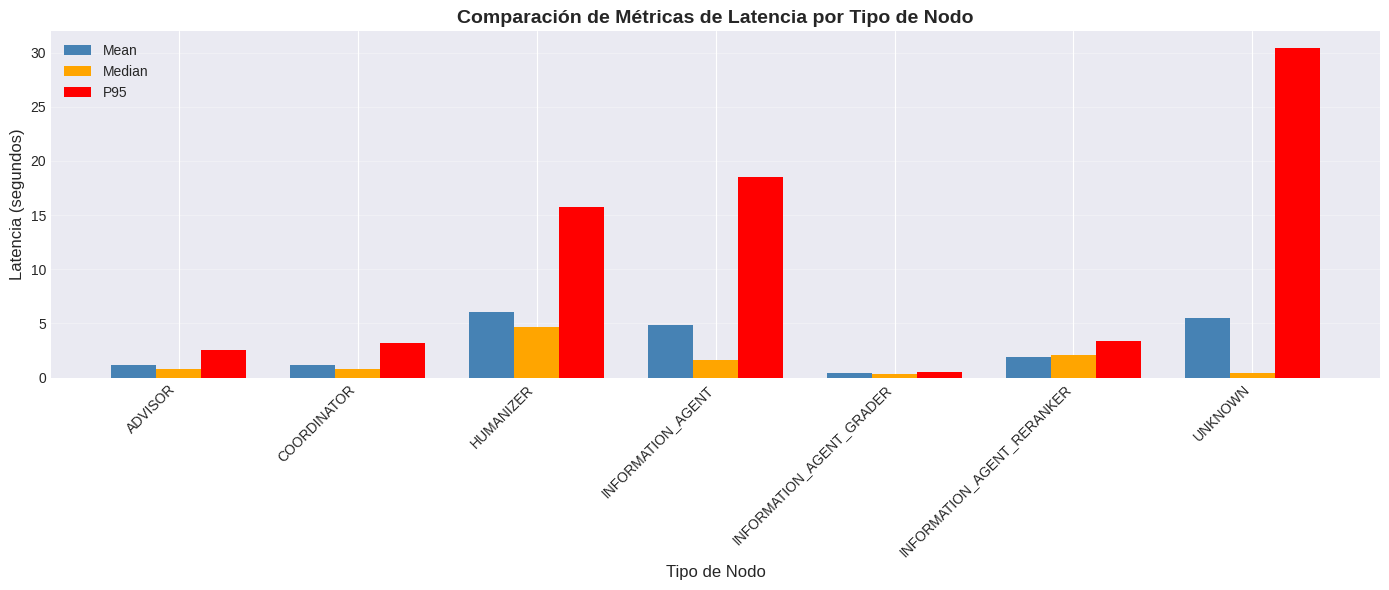

In [15]:
def plot_latency_comparison(latency_cube):
    """
    Compara métricas de latencia promedio por tipo de nodo.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(latency_cube))
    width = 0.25
    
    # Crear barras para mean, median y p95
    bars1 = ax.bar(x - width, latency_cube['latency_mean'], width, 
                   label='Mean', color='steelblue')
    bars2 = ax.bar(x, latency_cube['latency_median'], width, 
                   label='Median', color='orange')
    bars3 = ax.bar(x + width, latency_cube['latency_p95'], width, 
                   label='P95', color='red')
    
    ax.set_xlabel('Tipo de Nodo', fontsize=12)
    ax.set_ylabel('Latencia (segundos)', fontsize=12)
    ax.set_title('Comparación de Métricas de Latencia por Tipo de Nodo', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(latency_cube['node_type'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_latency_comparison(latency_cube)

### 4.5 Series Temporales: Evolución Diaria

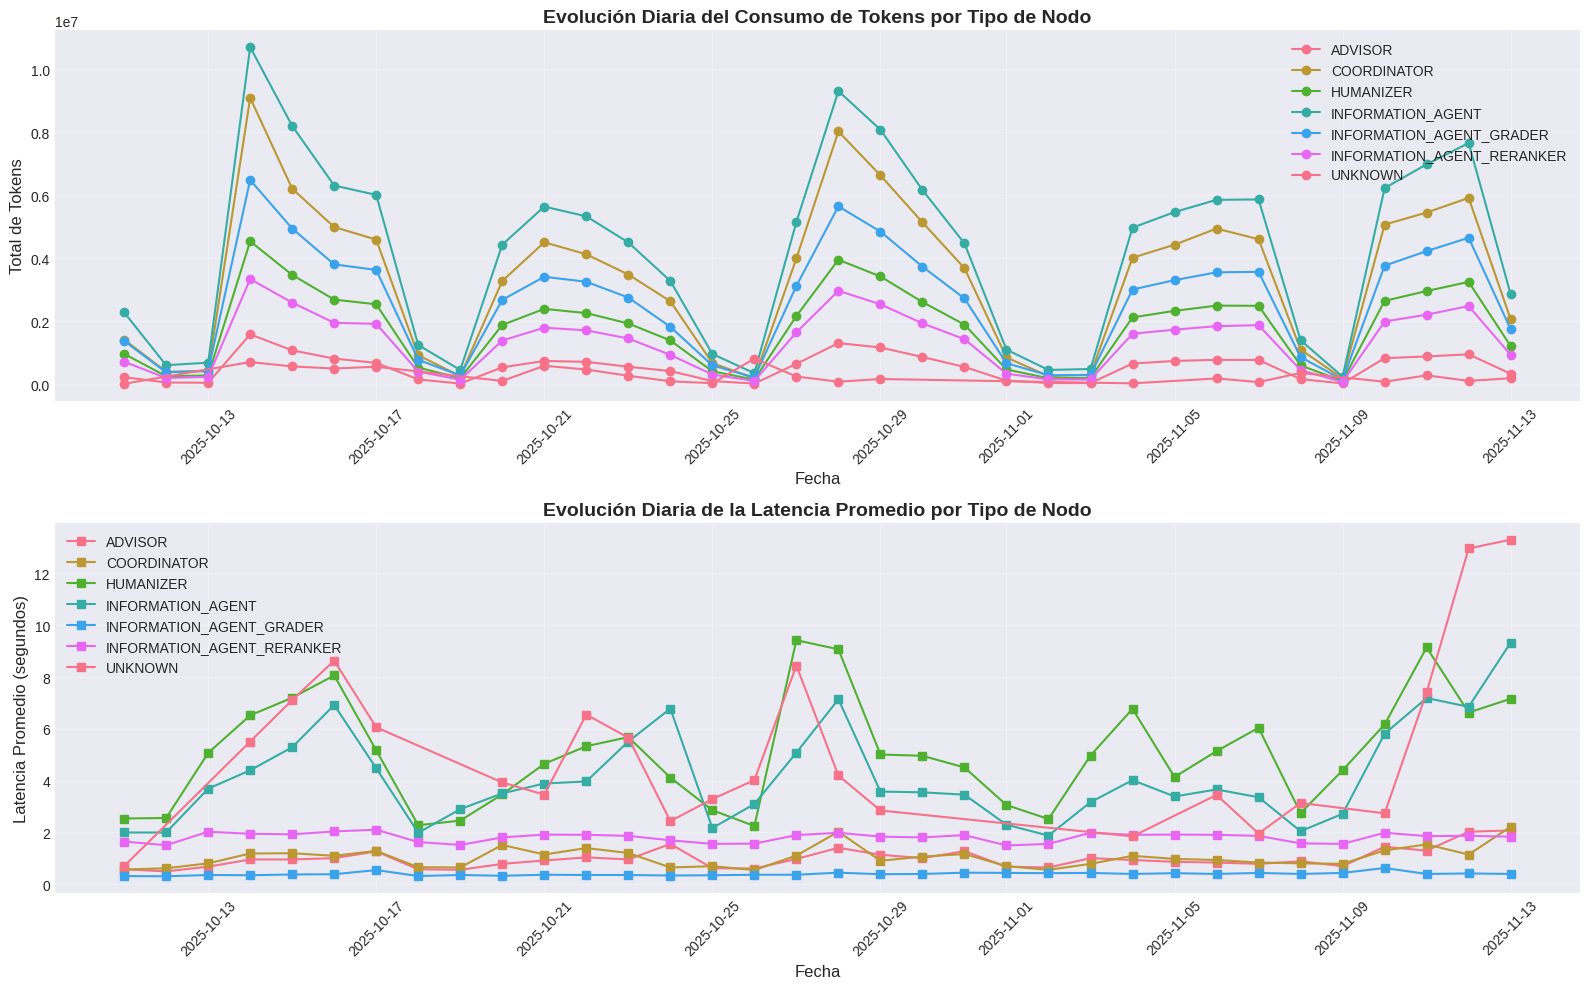

In [16]:
def plot_daily_trends(daily_cube):
    """
    Visualiza tendencias diarias de tokens y latencias.
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Convertir date a datetime para mejor visualización
    daily_cube['date'] = pd.to_datetime(daily_cube['date'])
    
    # Gráfico 1: Evolución de tokens totales
    ax1 = axes[0]
    for node_type in daily_cube['node_type'].unique():
        data = daily_cube[daily_cube['node_type'] == node_type]
        ax1.plot(data['date'], data['totalTokens_sum'], marker='o', label=node_type)
    
    ax1.set_xlabel('Fecha', fontsize=12)
    ax1.set_ylabel('Total de Tokens', fontsize=12)
    ax1.set_title('Evolución Diaria del Consumo de Tokens por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Evolución de latencia promedio
    ax2 = axes[1]
    for node_type in daily_cube['node_type'].unique():
        data = daily_cube[daily_cube['node_type'] == node_type]
        ax2.plot(data['date'], data['latency_mean'], marker='s', label=node_type)
    
    ax2.set_xlabel('Fecha', fontsize=12)
    ax2.set_ylabel('Latencia Promedio (segundos)', fontsize=12)
    ax2.set_title('Evolución Diaria de la Latencia Promedio por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


plot_daily_trends(daily_cube)

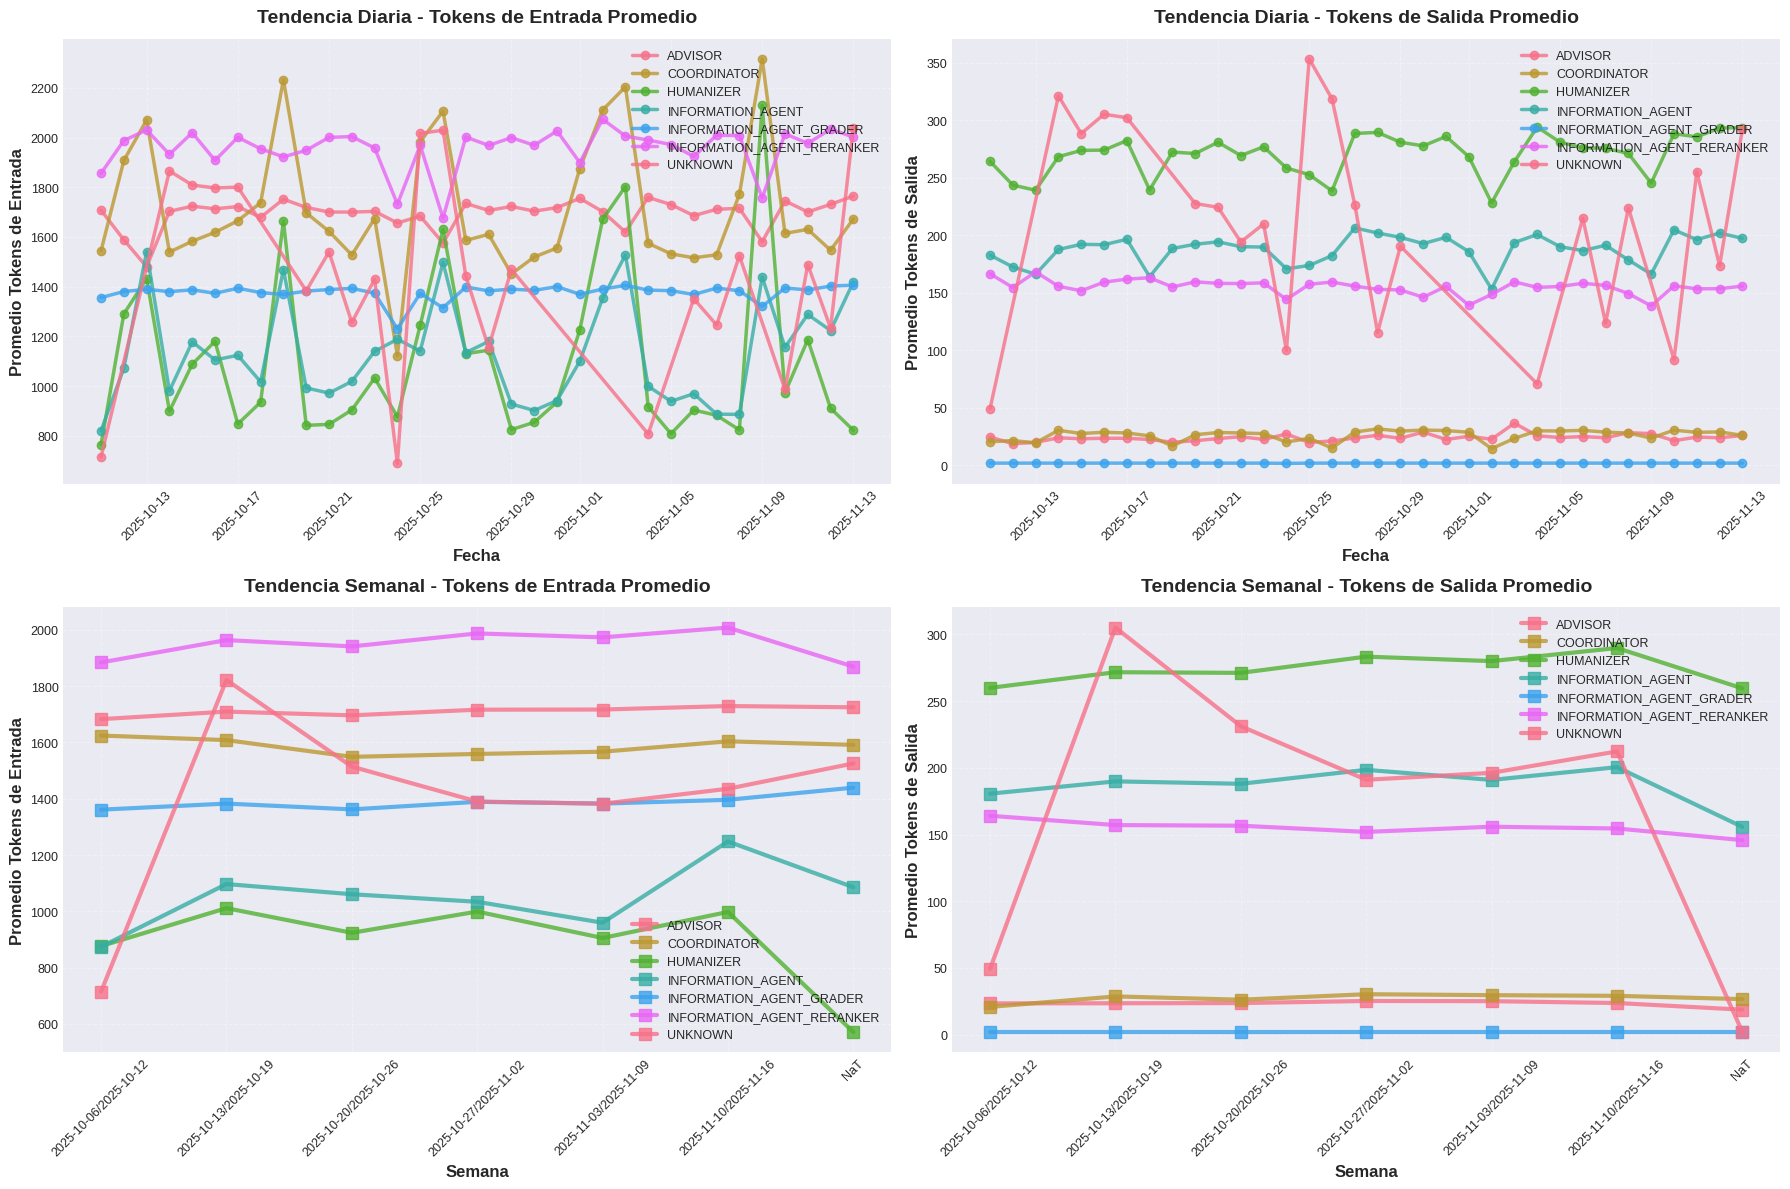

In [17]:
def plot_token_trends_simple(daily_cube, weekly_cube):
    """
    Visualiza tendencias simplificadas de tokens promedio (entrada vs salida, diaria y semanal).
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Preparar datos diarios
    daily_cube_copy = daily_cube.copy()
    daily_cube_copy['date'] = pd.to_datetime(daily_cube_copy['date'])
    
    # Gráfico 1: Tendencia Diaria - Tokens de Entrada
    ax1 = axes[0, 0]
    for node_type in sorted(daily_cube_copy['node_type'].unique()):
        data = daily_cube_copy[daily_cube_copy['node_type'] == node_type]
        ax1.plot(data['date'], data['promptTokens_mean'], marker='o', label=node_type, 
                linewidth=2.5, markersize=6, alpha=0.8)
    
    ax1.set_xlabel('Fecha', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Promedio Tokens de Entrada', fontsize=12, fontweight='bold')
    ax1.set_title('Tendencia Diaria - Tokens de Entrada Promedio', 
                  fontsize=14, fontweight='bold', pad=12)
    ax1.legend(loc='best', fontsize=9, framealpha=0.9)
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45, labelsize=9)
    ax1.tick_params(axis='y', labelsize=9)
    
    # Gráfico 2: Tendencia Diaria - Tokens de Salida
    ax2 = axes[0, 1]
    for node_type in sorted(daily_cube_copy['node_type'].unique()):
        data = daily_cube_copy[daily_cube_copy['node_type'] == node_type]
        ax2.plot(data['date'], data['completionTokens_mean'], marker='o', label=node_type, 
                linewidth=2.5, markersize=6, alpha=0.8)
    
    ax2.set_xlabel('Fecha', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Promedio Tokens de Salida', fontsize=12, fontweight='bold')
    ax2.set_title('Tendencia Diaria - Tokens de Salida Promedio', 
                  fontsize=14, fontweight='bold', pad=12)
    ax2.legend(loc='best', fontsize=9, framealpha=0.9)
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.tick_params(axis='y', labelsize=9)
    
    # Gráfico 3: Tendencia Semanal - Tokens de Entrada
    ax3 = axes[1, 0]
    for node_type in sorted(weekly_cube['node_type'].unique()):
        data = weekly_cube[weekly_cube['node_type'] == node_type]
        ax3.plot(data['week'], data['promptTokens_mean'], marker='s', label=node_type, 
                linewidth=3, markersize=8, alpha=0.8)
    
    ax3.set_xlabel('Semana', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Promedio Tokens de Entrada', fontsize=12, fontweight='bold')
    ax3.set_title('Tendencia Semanal - Tokens de Entrada Promedio', 
                  fontsize=14, fontweight='bold', pad=12)
    ax3.legend(loc='best', fontsize=9, framealpha=0.9)
    ax3.grid(alpha=0.3, linestyle='--')
    ax3.tick_params(axis='x', rotation=45, labelsize=9)
    ax3.tick_params(axis='y', labelsize=9)
    
    # Gráfico 4: Tendencia Semanal - Tokens de Salida
    ax4 = axes[1, 1]
    for node_type in sorted(weekly_cube['node_type'].unique()):
        data = weekly_cube[weekly_cube['node_type'] == node_type]
        ax4.plot(data['week'], data['completionTokens_mean'], marker='s', label=node_type, 
                linewidth=3, markersize=8, alpha=0.8)
    
    ax4.set_xlabel('Semana', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Promedio Tokens de Salida', fontsize=12, fontweight='bold')
    ax4.set_title('Tendencia Semanal - Tokens de Salida Promedio', 
                  fontsize=14, fontweight='bold', pad=12)
    ax4.legend(loc='best', fontsize=9, framealpha=0.9)
    ax4.grid(alpha=0.3, linestyle='--')
    ax4.tick_params(axis='x', rotation=45, labelsize=9)
    ax4.tick_params(axis='y', labelsize=9)
    
    plt.tight_layout()
    plt.show()


plot_token_trends_simple(daily_cube, weekly_cube)

def export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, 
                          unknown_sample=None, output_file='cubos_analisis_langgraph.xlsx'):
    """
    Exporta todos los cubos de datos a un archivo Excel con múltiples hojas.
    
    Args:
        token_cube: DataFrame con cubo de tokens
        latency_cube: DataFrame con cubo de latencias
        daily_cube: DataFrame con agregación diaria
        weekly_cube: DataFrame con agregación semanal
        summary_cube: DataFrame con resumen general
        unknown_sample: DataFrame con muestra de registros UNKNOWN (opcional)
        output_file: Ruta del archivo de salida
    """
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        token_cube.to_excel(writer, sheet_name='Tokens', index=False)
        latency_cube.to_excel(writer, sheet_name='Latencias', index=False)
        daily_cube.to_excel(writer, sheet_name='Agregacion_Diaria', index=False)
        weekly_cube.to_excel(writer, sheet_name='Agregacion_Semanal', index=False)
        summary_cube.to_excel(writer, sheet_name='Resumen_General', index=False)
        
        # Añadir hoja con muestra de UNKNOWN si existe
        if unknown_sample is not None and not unknown_sample.empty:
            unknown_sample.to_excel(writer, sheet_name='Muestra_UNKNOWN', index=False)
    
    print(f"✅ Cubos exportados exitosamente a: {output_file}")


def export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, 
                        unknown_sample=None, output_dir='data/cubos_output'):
    """
    Exporta todos los cubos de datos a archivos CSV individuales.
    
    Args:
        token_cube: DataFrame con cubo de tokens
        latency_cube: DataFrame con cubo de latencias
        daily_cube: DataFrame con agregación diaria
        weekly_cube: DataFrame con agregación semanal
        summary_cube: DataFrame con resumen general
        unknown_sample: DataFrame con muestra de registros UNKNOWN (opcional)
        output_dir: Directorio de salida
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    token_cube.to_csv(f'{output_dir}/cubo_tokens.csv', index=False)
    latency_cube.to_csv(f'{output_dir}/cubo_latencias.csv', index=False)
    daily_cube.to_csv(f'{output_dir}/cubo_agregacion_diaria.csv', index=False)
    weekly_cube.to_csv(f'{output_dir}/cubo_agregacion_semanal.csv', index=False)
    summary_cube.to_csv(f'{output_dir}/cubo_resumen_general.csv', index=False)
    
    # Exportar muestra de UNKNOWN si existe
    if unknown_sample is not None and not unknown_sample.empty:
        unknown_sample.to_csv(f'{output_dir}/muestra_unknown.csv', index=False)
    
    print(f"✅ Cubos exportados exitosamente a: {output_dir}/")


# Exportar a Excel (incluyendo muestra de UNKNOWN si existe)
export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, unknown_sample)

# Exportar a CSV
export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, unknown_sample)

In [35]:
# Exportar cubos de latencias por modelo
print("💾 Exportando cubos de latencias por modelo...\n")

export_latency_cubes_by_model(
    mini_latency_daily, 
    mini_latency_weekly, 
    gpt41_latency_daily, 
    gpt41_latency_weekly
)

💾 Exportando cubos de latencias por modelo...

📊 Exportando cubos de latencias a CSV...
   ✅ data/cubos_output/latency_cube_gpt41mini_daily.csv
   ✅ data/cubos_output/latency_cube_gpt41mini_weekly.csv
   ✅ data/cubos_output/latency_cube_gpt41_daily.csv
   ✅ data/cubos_output/latency_cube_gpt41_weekly.csv

📊 Exportando a Excel consolidado: analisis_latencias_por_modelo.xlsx
   ✅ analisis_latencias_por_modelo.xlsx

✅ Exportación completada exitosamente



📈 Generando visualización comparativa GPT-4.1 Mini vs GPT-4.1...



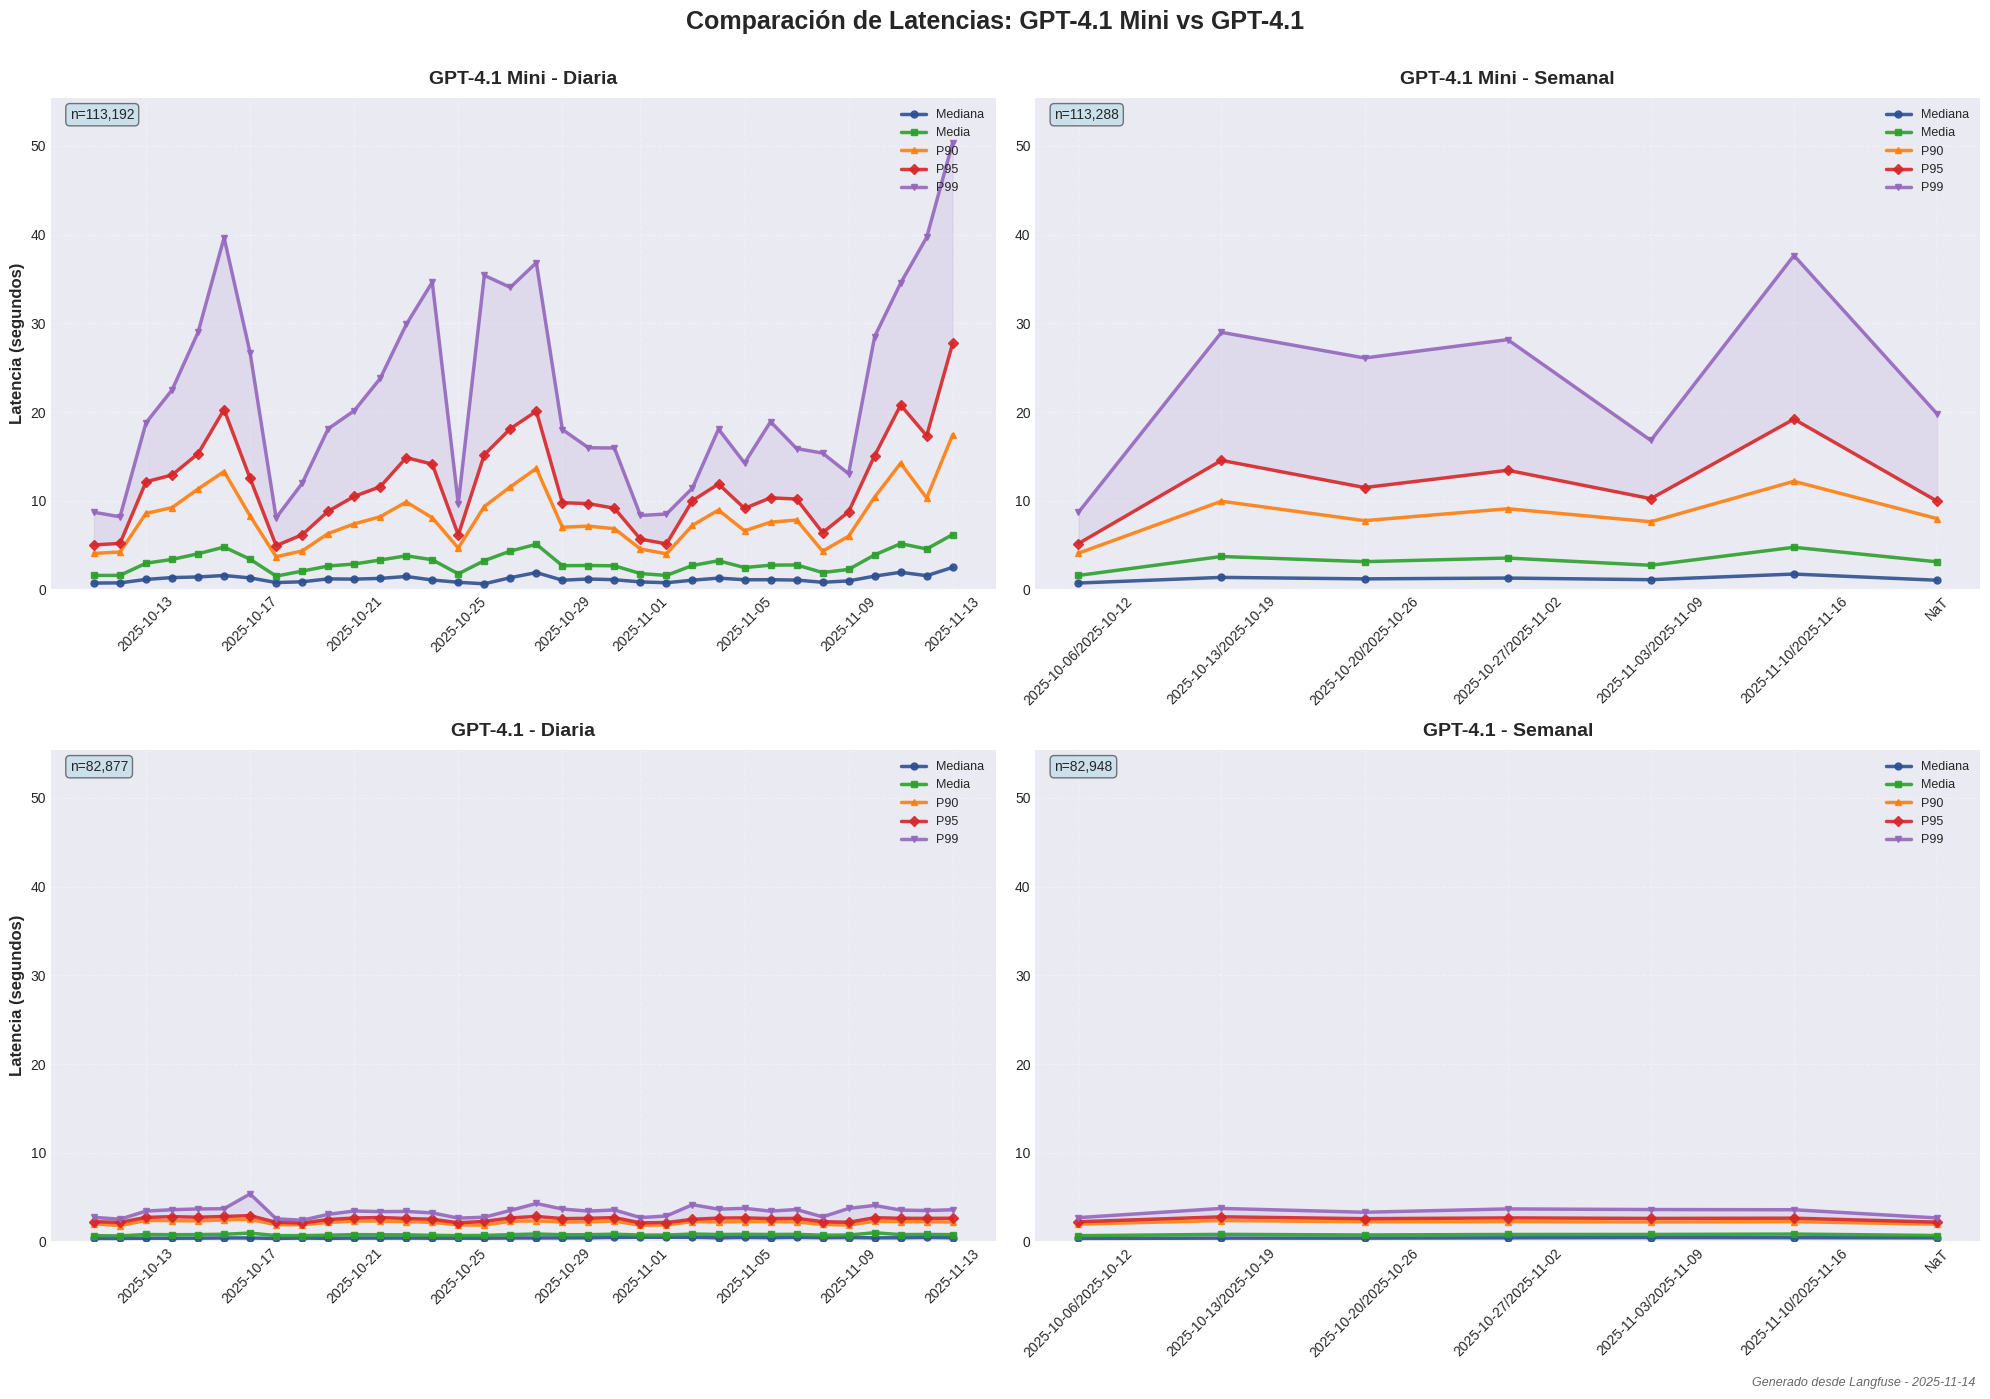

In [36]:
# Visualización comparativa 2x2
print("📈 Generando visualización comparativa GPT-4.1 Mini vs GPT-4.1...\n")

# Verificar que hay datos suficientes
has_mini_data = not mini_latency_daily.empty and not mini_latency_weekly.empty
has_gpt41_data = not gpt41_latency_daily.empty and not gpt41_latency_weekly.empty

if has_mini_data and has_gpt41_data:
    plot_latency_comparison_models(mini_latency_daily, mini_latency_weekly, 
                                   gpt41_latency_daily, gpt41_latency_weekly)
elif has_mini_data:
    print("⚠️ Solo hay datos de GPT-4.1 Mini. Mostrando solo esa visualización.")
    plot_latency_trends_by_model(mini_latency_daily, mini_latency_weekly, "GPT-4.1 Mini")
elif has_gpt41_data:
    print("⚠️ Solo hay datos de GPT-4.1. Mostrando solo esa visualización.")
    plot_latency_trends_by_model(gpt41_latency_daily, gpt41_latency_weekly, "GPT-4.1")
else:
    print("❌ No hay datos suficientes para generar visualizaciones comparativas")

### 5.4 Visualización Comparativa y Exportación

📈 Generando visualización de tendencias para GPT-4.1...



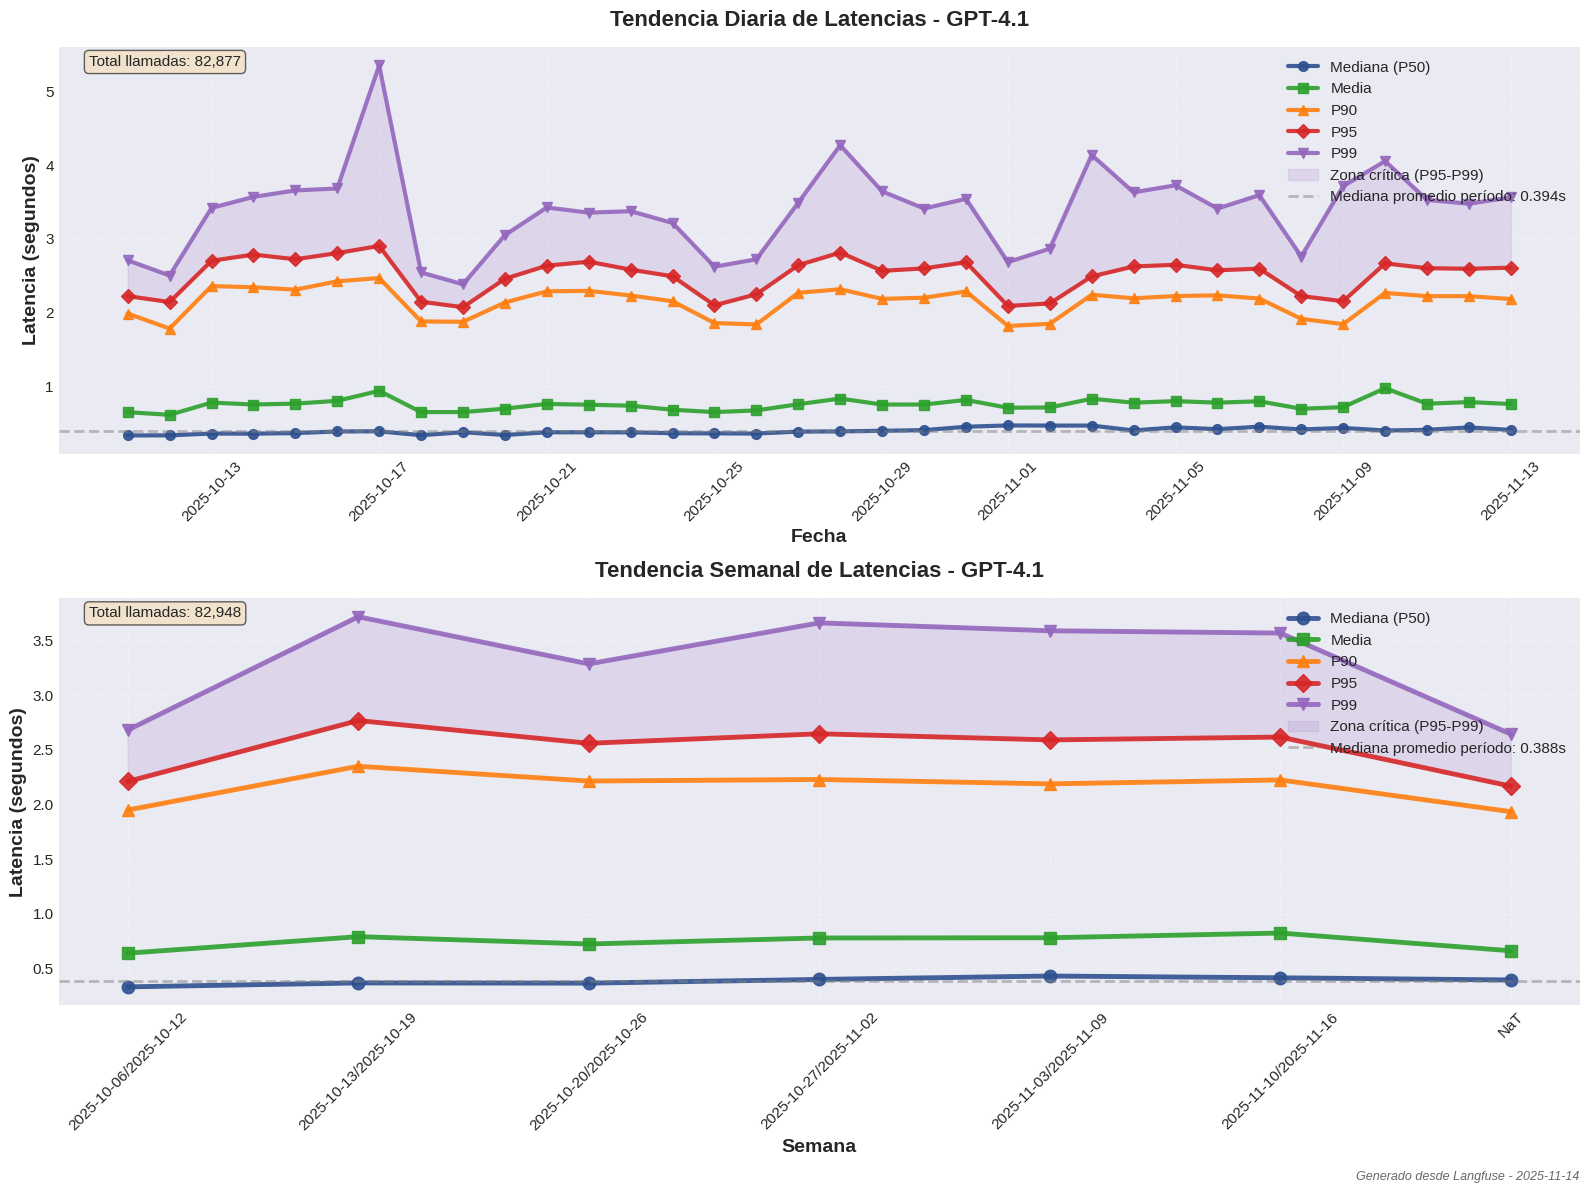

In [37]:
# Visualizar tendencias de GPT-4.1
if not gpt41_latency_daily.empty and not gpt41_latency_weekly.empty:
    print("📈 Generando visualización de tendencias para GPT-4.1...\n")
    plot_latency_trends_by_model(gpt41_latency_daily, gpt41_latency_weekly, "GPT-4.1")
else:
    print("⚠️ No hay suficientes datos para generar la visualización de GPT-4.1")

In [34]:
# Filtro para GPT-4.1 (sin Mini): contiene "4.1" pero NO "mini"
gpt41_filter = lambda x: '4.1' in str(x).lower() and 'mini' not in str(x).lower()

# Generar cubos de latencias para GPT-4.1
print("🔍 Generando cubos de latencias para GPT-4.1 (sin Mini)...\n")

gpt41_latency_daily = create_latency_cube_by_model(df, gpt41_filter, temporal='daily')
gpt41_latency_weekly = create_latency_cube_by_model(df, gpt41_filter, temporal='weekly')

if not gpt41_latency_daily.empty:
    print(f"\n✅ Cubo diario generado: {len(gpt41_latency_daily)} días")
    print(f"   Total de llamadas: {gpt41_latency_daily['total_calls'].sum():,}")
    print(f"   Mediana promedio: {gpt41_latency_daily['latency_median'].mean():.3f}s")
    print(f"   P95 promedio: {gpt41_latency_daily['latency_p95'].mean():.3f}s\n")
    
    print("📊 Primeras 5 filas del cubo diario:")
    display(gpt41_latency_daily.head())
else:
    print("⚠️ No se generaron datos para GPT-4.1")

if not gpt41_latency_weekly.empty:
    print(f"\n✅ Cubo semanal generado: {len(gpt41_latency_weekly)} semanas")
    print(f"   Total de llamadas: {gpt41_latency_weekly['total_calls'].sum():,}\n")

🔍 Generando cubos de latencias para GPT-4.1 (sin Mini)...


✅ Cubo diario generado: 34 días
   Total de llamadas: 82,877
   Mediana promedio: 0.394s
   P95 promedio: 2.501s

📊 Primeras 5 filas del cubo diario:


,date,total_calls,latency_mean,latency_median,latency_min,latency_max,latency_p90,latency_p95,latency_p99
0,2025-10-11,1323,0.648,0.332,0.223,3.010,1.987,2.224,2.710
1,2025-10-12,360,0.612,0.333,0.216,3.351,1.783,2.143,2.503
2,2025-10-13,400,0.778,0.358,0.234,4.771,2.360,2.703,3.421
3,2025-10-14,6195,0.752,0.356,0.220,9.050,2.344,2.788,3.571
4,2025-10-15,4700,0.764,0.364,0.228,22.524,2.311,2.724,3.659



✅ Cubo semanal generado: 7 semanas
   Total de llamadas: 82,948



### 5.3 Análisis GPT-4.1 (sin Mini)

📈 Generando visualización de tendencias para GPT-4.1 Mini...



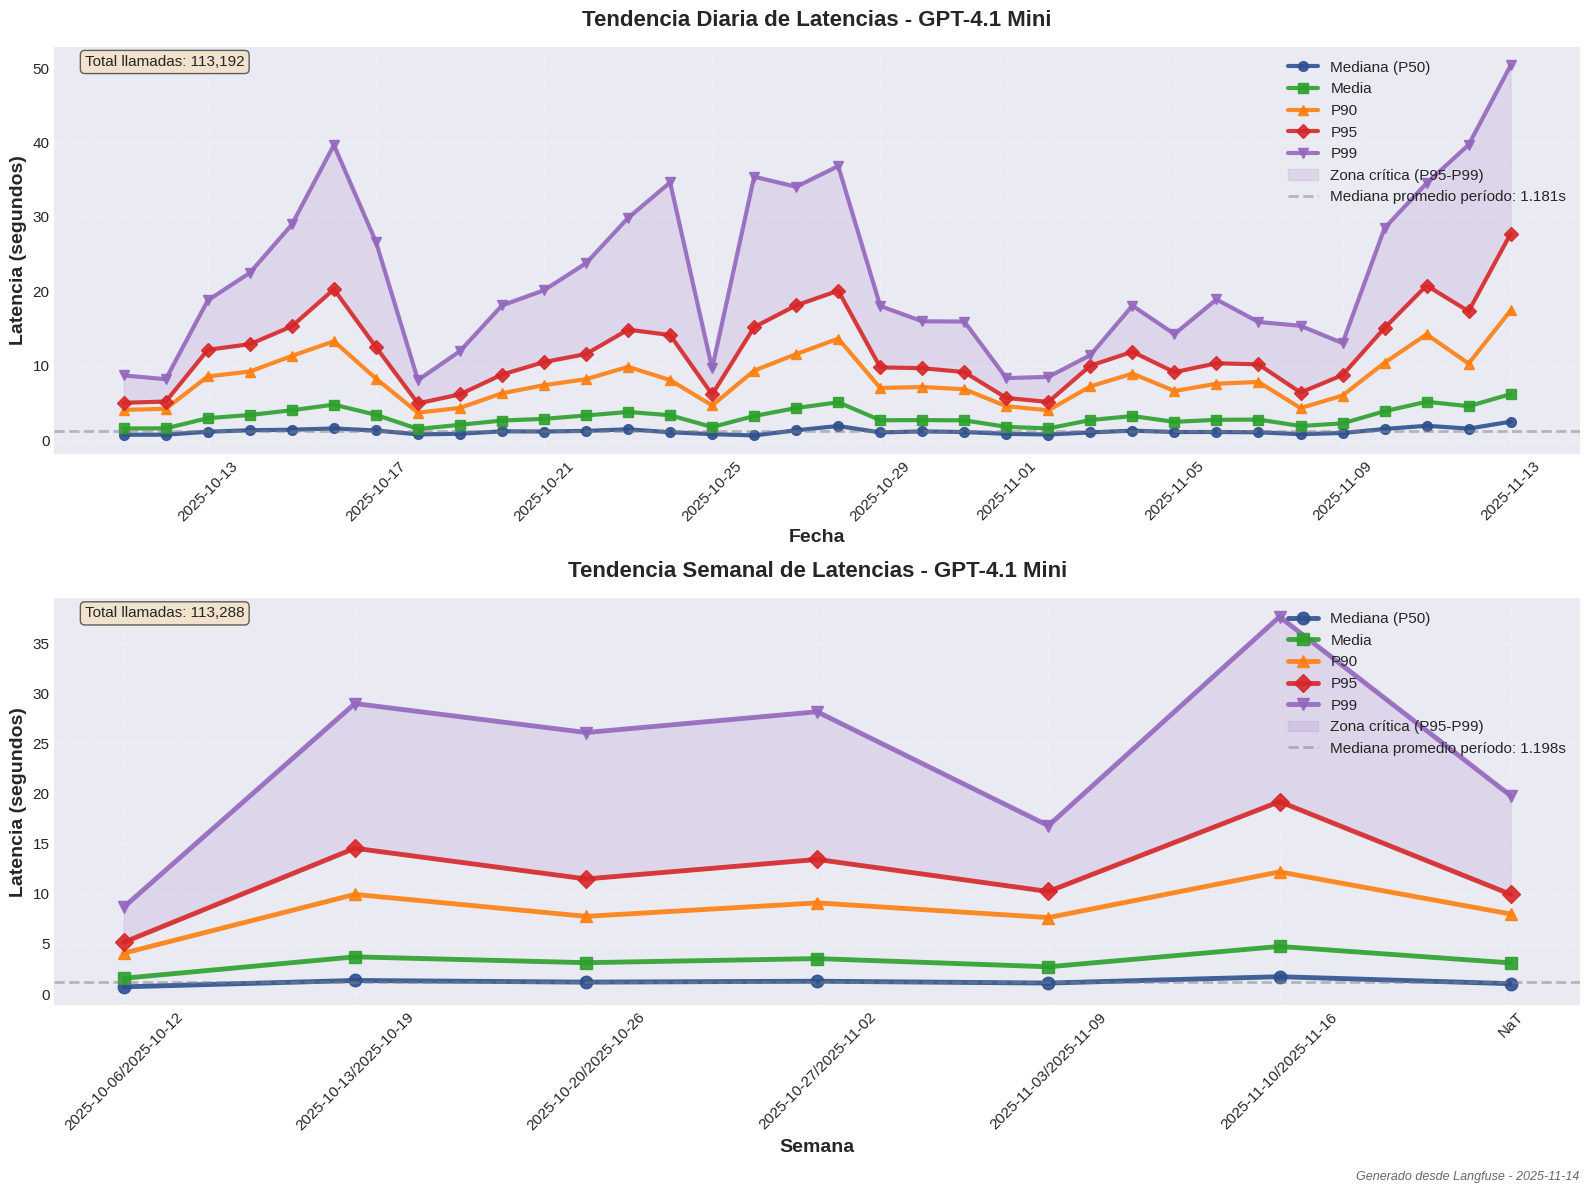

In [38]:
# Visualizar tendencias de GPT-4.1 Mini
if not mini_latency_daily.empty and not mini_latency_weekly.empty:
    print("📈 Generando visualización de tendencias para GPT-4.1 Mini...\n")
    plot_latency_trends_by_model(mini_latency_daily, mini_latency_weekly, "GPT-4.1 Mini")
else:
    print("⚠️ No hay suficientes datos para generar la visualización de GPT-4.1 Mini")

In [30]:
# Filtro para GPT-4.1 Mini: contiene "mini" (case-insensitive)
mini_filter = lambda x: 'mini' in str(x).lower()

# Generar cubos de latencias para GPT-4.1 Mini
print("🔍 Generando cubos de latencias para GPT-4.1 Mini...\n")

mini_latency_daily = create_latency_cube_by_model(df, mini_filter, temporal='daily')
mini_latency_weekly = create_latency_cube_by_model(df, mini_filter, temporal='weekly')

if not mini_latency_daily.empty:
    print(f"\n✅ Cubo diario generado: {len(mini_latency_daily)} días")
    print(f"   Total de llamadas: {mini_latency_daily['total_calls'].sum():,}")
    print(f"   Mediana promedio: {mini_latency_daily['latency_median'].mean():.3f}s")
    print(f"   P95 promedio: {mini_latency_daily['latency_p95'].mean():.3f}s\n")
    
    print("📊 Primeras 5 filas del cubo diario:")
    display(mini_latency_daily.head())
else:
    print("⚠️ No se generaron datos para GPT-4.1 Mini")

if not mini_latency_weekly.empty:
    print(f"\n✅ Cubo semanal generado: {len(mini_latency_weekly)} semanas")
    print(f"   Total de llamadas: {mini_latency_weekly['total_calls'].sum():,}\n")

🔍 Generando cubos de latencias para GPT-4.1 Mini...


✅ Cubo diario generado: 34 días
   Total de llamadas: 113,192
   Mediana promedio: 1.181s
   P95 promedio: 11.789s

📊 Primeras 5 filas del cubo diario:


,date,total_calls,latency_mean,latency_median,latency_min,latency_max,latency_p90,latency_p95,latency_p99
0,2025-10-11,1592,1.569,0.714,0.235,18.056,4.061,5.015,8.695
1,2025-10-12,432,1.583,0.732,0.276,12.289,4.212,5.186,8.190
2,2025-10-13,465,2.951,1.124,0.379,28.895,8.567,12.138,18.791
3,2025-10-14,8787,3.380,1.329,0.228,112.068,9.220,12.899,22.488
4,2025-10-15,6396,4.015,1.400,0.249,105.642,11.318,15.301,28.988



✅ Cubo semanal generado: 7 semanas
   Total de llamadas: 113,288



### 5.2 Análisis GPT-4.1 Mini

In [24]:
def export_latency_cubes_by_model(mini_daily, mini_weekly, gpt41_daily, gpt41_weekly,
                                  output_dir='data/cubos_output', excel_file='analisis_latencias_por_modelo.xlsx'):
    """
    Exporta cubos de latencias por modelo a CSV y Excel.
    
    Args:
        mini_daily: DataFrame con latencias diarias GPT-4.1 Mini
        mini_weekly: DataFrame con latencias semanales GPT-4.1 Mini
        gpt41_daily: DataFrame con latencias diarias GPT-4.1
        gpt41_weekly: DataFrame con latencias semanales GPT-4.1
        output_dir: Directorio para archivos CSV
        excel_file: Nombre del archivo Excel consolidado
    """
    import os
    
    # Crear directorio si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Exportar a CSV individuales
    print("📊 Exportando cubos de latencias a CSV...")
    
    if not mini_daily.empty:
        mini_daily.to_csv(f'{output_dir}/latency_cube_gpt41mini_daily.csv', index=False)
        print(f"   ✅ {output_dir}/latency_cube_gpt41mini_daily.csv")
    
    if not mini_weekly.empty:
        mini_weekly.to_csv(f'{output_dir}/latency_cube_gpt41mini_weekly.csv', index=False)
        print(f"   ✅ {output_dir}/latency_cube_gpt41mini_weekly.csv")
    
    if not gpt41_daily.empty:
        gpt41_daily.to_csv(f'{output_dir}/latency_cube_gpt41_daily.csv', index=False)
        print(f"   ✅ {output_dir}/latency_cube_gpt41_daily.csv")
    
    if not gpt41_weekly.empty:
        gpt41_weekly.to_csv(f'{output_dir}/latency_cube_gpt41_weekly.csv', index=False)
        print(f"   ✅ {output_dir}/latency_cube_gpt41_weekly.csv")
    
    # Exportar a Excel consolidado
    print(f"\n📊 Exportando a Excel consolidado: {excel_file}")
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        if not mini_daily.empty:
            mini_daily.to_excel(writer, sheet_name='GPT41Mini_Diario', index=False)
        if not mini_weekly.empty:
            mini_weekly.to_excel(writer, sheet_name='GPT41Mini_Semanal', index=False)
        if not gpt41_daily.empty:
            gpt41_daily.to_excel(writer, sheet_name='GPT41_Diario', index=False)
        if not gpt41_weekly.empty:
            gpt41_weekly.to_excel(writer, sheet_name='GPT41_Semanal', index=False)
    
    print(f"   ✅ {excel_file}")
    print("\n✅ Exportación completada exitosamente\n")


print("✅ Función export_latency_cubes_by_model definida")

✅ Función export_latency_cubes_by_model definida


In [25]:
def plot_latency_comparison_models(mini_daily, mini_weekly, gpt41_daily, gpt41_weekly):
    """
    Visualización comparativa 2x2 de latencias entre GPT-4.1 Mini y GPT-4.1.
    
    Layout:
    - Fila superior: GPT-4.1 Mini (Diaria | Semanal)
    - Fila inferior: GPT-4.1 (Diaria | Semanal)
    
    Args:
        mini_daily: DataFrame con latencias diarias de GPT-4.1 Mini
        mini_weekly: DataFrame con latencias semanales de GPT-4.1 Mini
        gpt41_daily: DataFrame con latencias diarias de GPT-4.1
        gpt41_weekly: DataFrame con latencias semanales de GPT-4.1
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Colores consistentes
    colors = {
        'median': '#2E5090',
        'mean': '#2CA02C',
        'p90': '#FF7F0E',
        'p95': '#D62728',
        'p99': '#9467BD'
    }
    
    # Calcular rango común para el eje Y (para comparación justa)
    all_maxes = []
    for df in [mini_daily, mini_weekly, gpt41_daily, gpt41_weekly]:
        if not df.empty:
            all_maxes.append(df['latency_p99'].max())
    y_max = max(all_maxes) * 1.1 if all_maxes else 10
    
    # Función helper para plotear
    def plot_latency_metrics(ax, data, time_col, title, show_ylabel=True):
        if data.empty:
            ax.text(0.5, 0.5, 'Sin datos disponibles', ha='center', va='center', 
                   fontsize=14, transform=ax.transAxes)
            return
        
        # Preparar datos
        data_copy = data.copy()
        if time_col == 'date' and time_col in data_copy.columns:
            data_copy[time_col] = pd.to_datetime(data_copy[time_col])
        
        x_data = data_copy[time_col]
        
        # Plotear líneas
        ax.plot(x_data, data_copy['latency_median'], marker='o', label='Mediana', 
               color=colors['median'], linewidth=2.5, markersize=5, alpha=0.9)
        ax.plot(x_data, data_copy['latency_mean'], marker='s', label='Media', 
               color=colors['mean'], linewidth=2.5, markersize=5, alpha=0.9)
        ax.plot(x_data, data_copy['latency_p90'], marker='^', label='P90', 
               color=colors['p90'], linewidth=2.5, markersize=5, alpha=0.9)
        ax.plot(x_data, data_copy['latency_p95'], marker='D', label='P95', 
               color=colors['p95'], linewidth=2.5, markersize=5, alpha=0.9)
        ax.plot(x_data, data_copy['latency_p99'], marker='v', label='P99', 
               color=colors['p99'], linewidth=2.5, markersize=5, alpha=0.9)
        
        # Banda sombreada
        ax.fill_between(x_data, data_copy['latency_p95'], data_copy['latency_p99'],
                       color=colors['p99'], alpha=0.12)
        
        # Configuración
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        if show_ylabel:
            ax.set_ylabel('Latencia (segundos)', fontsize=12, fontweight='bold')
        ax.set_ylim(0, y_max)
        ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
        ax.grid(alpha=0.3, linestyle='--')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Anotación total llamadas
        total = data_copy['total_calls'].sum()
        ax.text(0.02, 0.98, f'n={total:,}', transform=ax.transAxes, 
               fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # Plotear cada subgráfica
    plot_latency_metrics(axes[0, 0], mini_daily, 'date', 'GPT-4.1 Mini - Diaria', show_ylabel=True)
    plot_latency_metrics(axes[0, 1], mini_weekly, 'week', 'GPT-4.1 Mini - Semanal', show_ylabel=False)
    plot_latency_metrics(axes[1, 0], gpt41_daily, 'date', 'GPT-4.1 - Diaria', show_ylabel=True)
    plot_latency_metrics(axes[1, 1], gpt41_weekly, 'week', 'GPT-4.1 - Semanal', show_ylabel=False)
    
    # Título general
    fig.suptitle('Comparación de Latencias: GPT-4.1 Mini vs GPT-4.1', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Nota al pie
    from datetime import datetime
    fig.text(0.99, 0.01, f'Generado desde Langfuse - {datetime.now().strftime("%Y-%m-%d")}', 
            ha='right', va='bottom', fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.99])
    plt.show()


print("✅ Función plot_latency_comparison_models definida")

✅ Función plot_latency_comparison_models definida


In [26]:
def plot_latency_trends_by_model(latency_cube_daily, latency_cube_weekly, model_name):
    """
    Visualiza tendencias de latencia para un modelo específico.
    
    Genera 2 subgráficas apiladas verticalmente (diaria y semanal) con 5 líneas
    de métricas de latencia cada una. Optimizado para presentaciones al comité.
    
    Args:
        latency_cube_daily: DataFrame con agregación diaria
        latency_cube_weekly: DataFrame con agregación semanal
        model_name: Nombre del modelo para el título
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Definir colores profesionales para las métricas
    colors = {
        'median': '#2E5090',      # Azul oscuro
        'mean': '#2CA02C',        # Verde
        'p90': '#FF7F0E',         # Naranja
        'p95': '#D62728',         # Rojo
        'p99': '#9467BD'          # Morado
    }
    
    # Preparar datos diarios
    daily_copy = latency_cube_daily.copy()
    if 'date' in daily_copy.columns:
        daily_copy['date'] = pd.to_datetime(daily_copy['date'])
    
    # Gráfico 1: Tendencia Diaria
    ax1 = axes[0]
    
    # Plotear las 5 líneas
    ax1.plot(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
             daily_copy['latency_median'], marker='o', label='Mediana (P50)', 
             color=colors['median'], linewidth=3, markersize=7, alpha=0.9)
    ax1.plot(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
             daily_copy['latency_mean'], marker='s', label='Media', 
             color=colors['mean'], linewidth=3, markersize=7, alpha=0.9)
    ax1.plot(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
             daily_copy['latency_p90'], marker='^', label='P90', 
             color=colors['p90'], linewidth=3, markersize=7, alpha=0.9)
    ax1.plot(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
             daily_copy['latency_p95'], marker='D', label='P95', 
             color=colors['p95'], linewidth=3, markersize=7, alpha=0.9)
    ax1.plot(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
             daily_copy['latency_p99'], marker='v', label='P99', 
             color=colors['p99'], linewidth=3, markersize=7, alpha=0.9)
    
    # Banda sombreada entre P95 y P99
    ax1.fill_between(daily_copy['date' if 'date' in daily_copy.columns else daily_copy.columns[0]], 
                      daily_copy['latency_p95'], daily_copy['latency_p99'],
                      color=colors['p99'], alpha=0.15, label='Zona crítica (P95-P99)')
    
    # Línea promedio del período
    overall_median = daily_copy['latency_median'].mean()
    ax1.axhline(y=overall_median, color='gray', linestyle='--', linewidth=2, alpha=0.5,
                label=f'Mediana promedio período: {overall_median:.3f}s')
    
    # Configuración del gráfico diario
    ax1.set_xlabel('Fecha', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Latencia (segundos)', fontsize=14, fontweight='bold')
    ax1.set_title(f'Tendencia Diaria de Latencias - {model_name}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.legend(loc='upper right', fontsize=11, framealpha=0.95, shadow=True)
    ax1.grid(alpha=0.3, linestyle='--', linewidth=0.8)
    ax1.tick_params(axis='x', rotation=45, labelsize=11)
    ax1.tick_params(axis='y', labelsize=11)
    
    # Añadir anotación con total de llamadas
    total_calls_daily = daily_copy['total_calls'].sum()
    ax1.text(0.02, 0.98, f'Total llamadas: {total_calls_daily:,}', 
             transform=ax1.transAxes, fontsize=11, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
    
    # Gráfico 2: Tendencia Semanal
    ax2 = axes[1]
    
    # Plotear las 5 líneas
    ax2.plot(latency_cube_weekly['week'], latency_cube_weekly['latency_median'], 
             marker='o', label='Mediana (P50)', color=colors['median'], 
             linewidth=3.5, markersize=9, alpha=0.9)
    ax2.plot(latency_cube_weekly['week'], latency_cube_weekly['latency_mean'], 
             marker='s', label='Media', color=colors['mean'], 
             linewidth=3.5, markersize=9, alpha=0.9)
    ax2.plot(latency_cube_weekly['week'], latency_cube_weekly['latency_p90'], 
             marker='^', label='P90', color=colors['p90'], 
             linewidth=3.5, markersize=9, alpha=0.9)
    ax2.plot(latency_cube_weekly['week'], latency_cube_weekly['latency_p95'], 
             marker='D', label='P95', color=colors['p95'], 
             linewidth=3.5, markersize=9, alpha=0.9)
    ax2.plot(latency_cube_weekly['week'], latency_cube_weekly['latency_p99'], 
             marker='v', label='P99', color=colors['p99'], 
             linewidth=3.5, markersize=9, alpha=0.9)
    
    # Banda sombreada entre P95 y P99
    ax2.fill_between(latency_cube_weekly['week'], 
                      latency_cube_weekly['latency_p95'], 
                      latency_cube_weekly['latency_p99'],
                      color=colors['p99'], alpha=0.15, label='Zona crítica (P95-P99)')
    
    # Línea promedio del período
    overall_median_weekly = latency_cube_weekly['latency_median'].mean()
    ax2.axhline(y=overall_median_weekly, color='gray', linestyle='--', linewidth=2, alpha=0.5,
                label=f'Mediana promedio período: {overall_median_weekly:.3f}s')
    
    # Configuración del gráfico semanal
    ax2.set_xlabel('Semana', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Latencia (segundos)', fontsize=14, fontweight='bold')
    ax2.set_title(f'Tendencia Semanal de Latencias - {model_name}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax2.legend(loc='upper right', fontsize=11, framealpha=0.95, shadow=True)
    ax2.grid(alpha=0.3, linestyle='--', linewidth=0.8)
    ax2.tick_params(axis='x', rotation=45, labelsize=11)
    ax2.tick_params(axis='y', labelsize=11)
    
    # Añadir anotación con total de llamadas
    total_calls_weekly = latency_cube_weekly['total_calls'].sum()
    ax2.text(0.02, 0.98, f'Total llamadas: {total_calls_weekly:,}', 
             transform=ax2.transAxes, fontsize=11, va='top', ha='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
    
    # Nota al pie
    from datetime import datetime
    fig.text(0.99, 0.01, f'Generado desde Langfuse - {datetime.now().strftime("%Y-%m-%d")}', 
             ha='right', va='bottom', fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0.02, 1, 1])
    plt.show()


print("✅ Función plot_latency_trends_by_model definida")

✅ Función plot_latency_trends_by_model definida


In [27]:
def create_latency_cube_by_model(df, model_filter, temporal='daily'):
    """
    Genera cubo de latencias agregado para un modelo específico.
    
    Combina TODOS los tipos de nodo que usan el modelo filtrado.
    Calcula estadísticas completas de latencia por período temporal.
    
    Args:
        df: DataFrame con datos procesados
        model_filter: Función lambda o string para filtrar modelo
                     Ejemplo: lambda x: 'mini' in str(x).lower()
                     Ejemplo: 'gpt-4.1-mini'
        temporal: 'daily' o 'weekly' para agregación temporal
    
    Returns:
        DataFrame: Cubo con métricas de latencia por período
    """
    # Filtrar por modelo
    if callable(model_filter):
        df_filtered = df[df['model'].apply(model_filter)].copy()
    else:
        df_filtered = df[df['model'] == model_filter].copy()
    
    # Verificar que hay datos
    if len(df_filtered) == 0:
        print(f"⚠️ No se encontraron registros para el filtro de modelo especificado")
        return pd.DataFrame()
    
    # Seleccionar columna temporal
    time_col = 'date' if temporal == 'daily' else 'week'
    
    # Agregar por período temporal (sin discriminar por tipo de nodo)
    latency_cube = df_filtered.groupby(time_col).agg({
        'id': 'count',
        'latency': [
            'mean', 
            'median',
            'min',
            'max',
            lambda x: x.quantile(0.90),  # P90
            lambda x: x.quantile(0.95),  # P95
            lambda x: x.quantile(0.99)   # P99
        ]
    }).round(3)
    
    # Renombrar columnas
    latency_cube.columns = ['total_calls', 'latency_mean', 'latency_median', 
                            'latency_min', 'latency_max', 'latency_p90', 
                            'latency_p95', 'latency_p99']
    
    latency_cube = latency_cube.reset_index()
    
    return latency_cube


print("✅ Función create_latency_cube_by_model definida")

✅ Función create_latency_cube_by_model definida


### 5.1 Funciones para Análisis por Modelo

## 5. Análisis Especializado: Latencias por Modelo Individual

Esta sección proporciona análisis detallado de latencias segmentado por modelo específico, ideal para presentaciones ejecutivas y comités técnicos.

### Modelos analizados:
- **GPT-4.1 Mini**: Modelo optimizado para respuestas rápidas y costo-efectivas
- **GPT-4.1**: Modelo estándar de mayor capacidad

### Métricas de latencia incluidas:
- **Media**: Promedio aritmético de todas las latencias
- **Mediana (P50)**: Valor central que divide el dataset en dos mitades
- **P90**: 90% de las llamadas tienen latencia menor o igual a este valor
- **P95**: 95% de las llamadas tienen latencia menor o igual a este valor
- **P99**: 99% de las llamadas tienen latencia menor o igual a este valor (outliers incluidos)

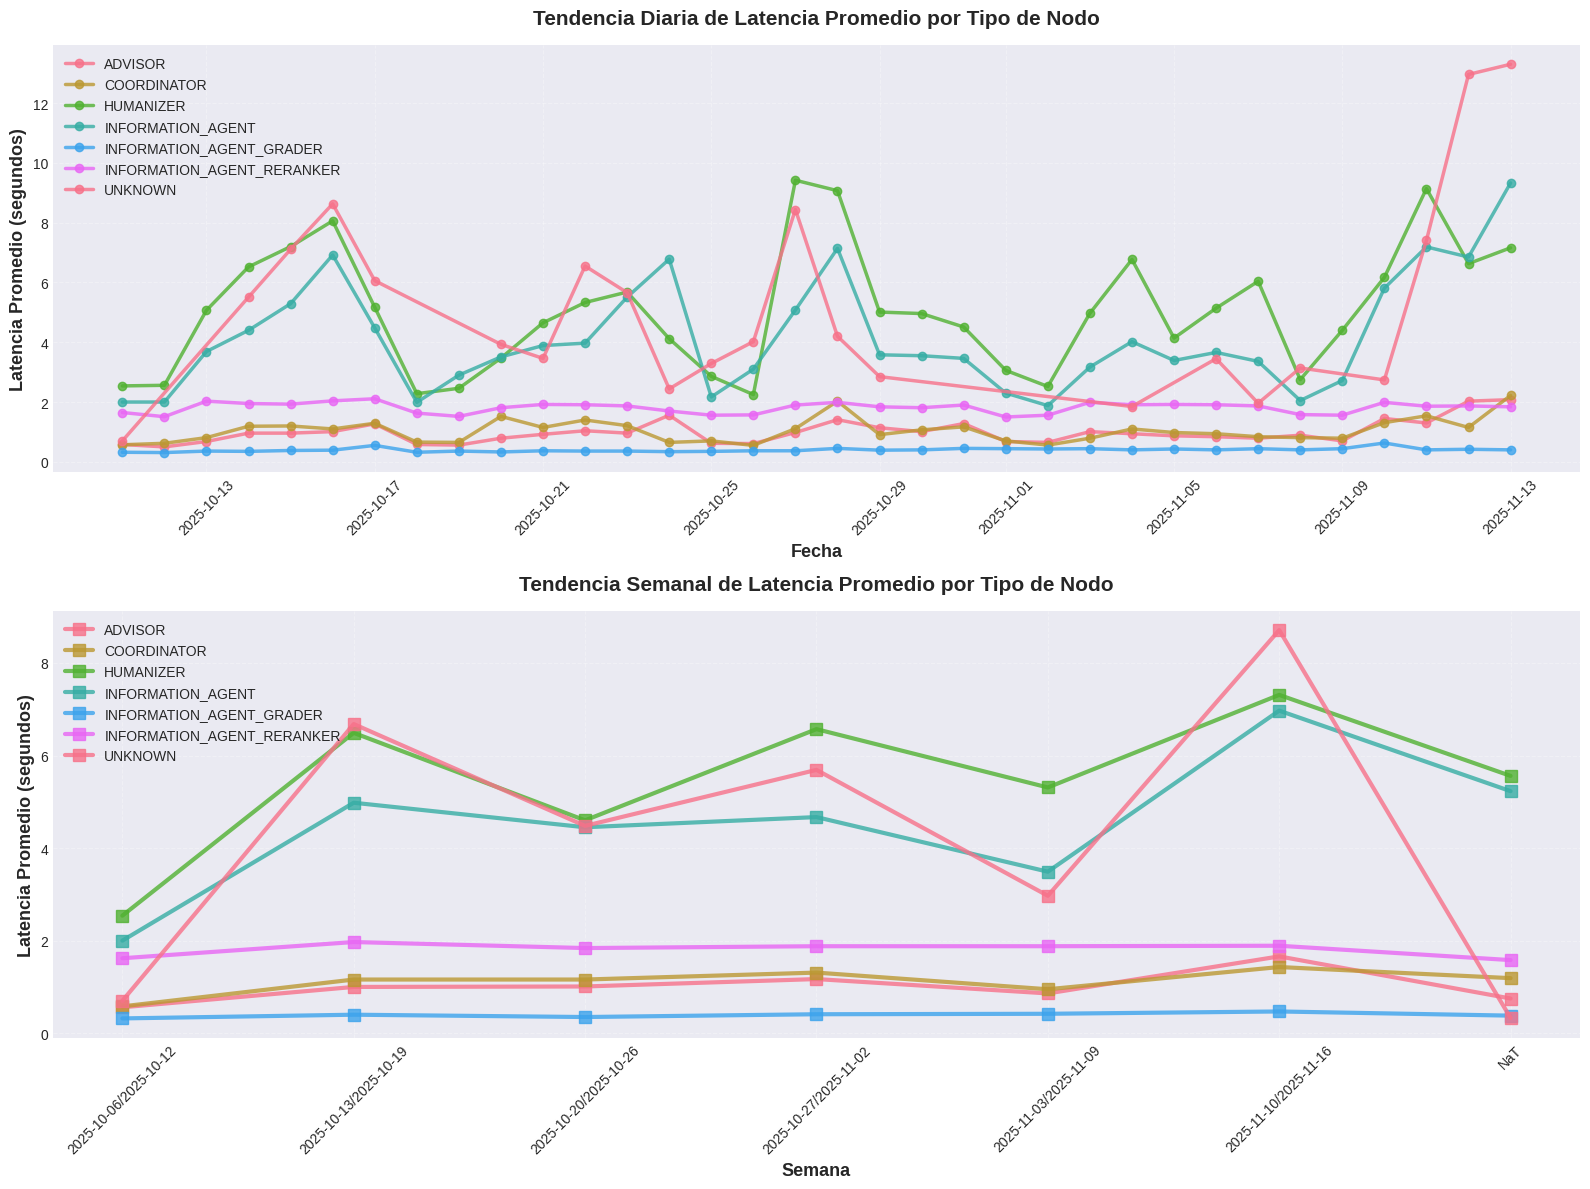

In [28]:
def plot_latency_trends_simple(daily_cube, weekly_cube):
    """
    Visualiza tendencias simplificadas de latencia promedio (diaria y semanal).
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Preparar datos diarios
    daily_cube_copy = daily_cube.copy()
    daily_cube_copy['date'] = pd.to_datetime(daily_cube_copy['date'])
    
    # Gráfico 1: Tendencia Diaria
    ax1 = axes[0]
    for node_type in sorted(daily_cube_copy['node_type'].unique()):
        data = daily_cube_copy[daily_cube_copy['node_type'] == node_type]
        ax1.plot(data['date'], data['latency_mean'], marker='o', label=node_type, 
                linewidth=2.5, markersize=6, alpha=0.8)
    
    ax1.set_xlabel('Fecha', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Latencia Promedio (segundos)', fontsize=13, fontweight='bold')
    ax1.set_title('Tendencia Diaria de Latencia Promedio por Tipo de Nodo', 
                  fontsize=15, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=10, framealpha=0.9)
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # Gráfico 2: Tendencia Semanal
    ax2 = axes[1]
    for node_type in sorted(weekly_cube['node_type'].unique()):
        data = weekly_cube[weekly_cube['node_type'] == node_type]
        ax2.plot(data['week'], data['latency_mean'], marker='s', label=node_type, 
                linewidth=3, markersize=8, alpha=0.8)
    
    ax2.set_xlabel('Semana', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Latencia Promedio (segundos)', fontsize=13, fontweight='bold')
    ax2.set_title('Tendencia Semanal de Latencia Promedio por Tipo de Nodo', 
                  fontsize=15, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()


plot_latency_trends_simple(daily_cube, weekly_cube)

### 4.8 Tendencias Simplificadas de Latencias Promedio

### 4.6 Series Temporales: Evolución Semanal

In [ ]:
def plot_weekly_trends(weekly_cube):
    """
    Visualiza tendencias semanales de tokens y latencias.
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Gráfico 1: Evolución semanal de tokens
    ax1 = axes[0]
    for node_type in weekly_cube['node_type'].unique():
        data = weekly_cube[weekly_cube['node_type'] == node_type]
        ax1.plot(data['week'], data['totalTokens_sum'], marker='o', label=node_type, linewidth=2)
    
    ax1.set_xlabel('Semana', fontsize=12)
    ax1.set_ylabel('Total de Tokens', fontsize=12)
    ax1.set_title('Evolución Semanal del Consumo de Tokens por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Evolución semanal de latencia
    ax2 = axes[1]
    for node_type in weekly_cube['node_type'].unique():
        data = weekly_cube[weekly_cube['node_type'] == node_type]
        ax2.plot(data['week'], data['latency_mean'], marker='s', label=node_type, linewidth=2)
    
    ax2.set_xlabel('Semana', fontsize=12)
    ax2.set_ylabel('Latencia Promedio (segundos)', fontsize=12)
    ax2.set_title('Evolución Semanal de la Latencia Promedio por Tipo de Nodo', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


plot_weekly_trends(weekly_cube)

### 4.7 Heatmap de Correlación de Métricas

In [ ]:
def generate_complete_analysis(csv_path, export_excel=True, export_csv=True, show_plots=True):
    """
    Función todo-en-uno para generar el análisis completo.
    
    Args:
        csv_path: Ruta al archivo CSV con datos de Langfuse
        export_excel: Si True, exporta cubos a Excel
        export_csv: Si True, exporta cubos a CSV
        show_plots: Si True, muestra visualizaciones
    
    Returns:
        dict: Diccionario con todos los cubos generados
    """
    print("🚀 Iniciando análisis completo...\n")
    
    # 1. Cargar datos
    df = pd.read_csv(csv_path)
    print(f"✅ Datos cargados: {len(df)} registros\n")
    
    # 2. Clasificar nodos
    df['node_type'] = df.apply(classify_node_type, axis=1)
    
    # 3. Procesar timestamps
    df['startTime'] = pd.to_datetime(df['startTime'], errors='coerce')
    df['endTime'] = pd.to_datetime(df['endTime'], errors='coerce')
    df['date'] = df['startTime'].dt.date
    df['week'] = df['startTime'].dt.to_period('W').astype(str)
    
    # 4. Convertir a numérico
    numeric_cols = ['promptTokens', 'completionTokens', 'totalTokens', 'latency', 
                    'timeToFirstToken', 'calculatedInputCost', 'calculatedOutputCost', 
                    'calculatedTotalCost']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 5. Generar cubos
    print("📊 Generando cubos de datos...")
    token_cube = create_token_consumption_cube(df)
    latency_cube = create_latency_analysis_cube(df)
    daily_cube = create_daily_aggregation_cube(df)
    weekly_cube = create_weekly_aggregation_cube(df)
    summary_cube = create_overall_summary_cube(df)
    model_cube = create_model_analysis_cube(df)
    trace_cube = create_trace_analysis_cube(df)
    
    # 5b. Exportar muestra de UNKNOWN
    unknown_sample = export_unknown_sample(df, sample_size=100)
    print("✅ Cubos generados\n")
    
    # 6. Exportar
    if export_excel:
        export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, 
                             summary_cube, unknown_sample)
    
    if export_csv:
        export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, 
                           summary_cube, unknown_sample)
    
    # 7. Visualizaciones
    if show_plots:
        print("\n📈 Generando visualizaciones...\n")
        plot_token_distribution(token_cube)
        plot_tokens_input_output_comparison(token_cube)
        plot_cost_analysis(token_cube)
        plot_latency_distribution(df)
        plot_latency_comparison(latency_cube)
        plot_latency_trends_simple(daily_cube, weekly_cube)
        plot_token_trends_simple(daily_cube, weekly_cube)
        plot_daily_trends(daily_cube)
        plot_weekly_trends(weekly_cube)
        plot_metrics_heatmap(df)
    
    # 8. Resumen ejecutivo
    generate_executive_summary(df, token_cube, latency_cube, summary_cube)
    
    return {
        'df': df,
        'token_cube': token_cube,
        'latency_cube': latency_cube,
        'daily_cube': daily_cube,
        'weekly_cube': weekly_cube,
        'summary_cube': summary_cube,
        'model_cube': model_cube,
        'trace_cube': trace_cube,
        'unknown_sample': unknown_sample
    }


# EJEMPLO DE USO:
# results = generate_complete_analysis('data/langfuse_observations.csv')
# Acceder a cubos individuales: results['token_cube'], results['latency_cube'], etc.

## 9. Notas y Recomendaciones

### Uso del Notebook:

1. **Configuración inicial**: Actualiza la variable `CSV_FILE_PATH` en la sección 2 con la ruta a tu archivo CSV de Langfuse.

2. **Ejecución completa**: Ejecuta todas las celdas secuencialmente, o utiliza la función `generate_complete_analysis()` para un análisis rápido.

3. **Personalización**: Todas las funciones están diseñadas para ser reutilizables. Puedes modificar las agregaciones según tus necesidades.

### Cubos Generados:

- **token_cube**: Consumo de tokens por tipo de nodo (incluye segmentación entrada/salida)
- **latency_cube**: Análisis estadístico de latencias
- **daily_cube**: Agregaciones diarias (incluye tokens de entrada y salida)
- **weekly_cube**: Agregaciones semanales (incluye tokens de entrada y salida)
- **summary_cube**: Resumen general con totales y promedios
- **model_cube**: Análisis por modelo y tipo de nodo
- **trace_cube**: Análisis por conversación completa
- **unknown_sample**: Muestra de registros UNKNOWN para análisis

### Exportación:

Los cubos se exportan automáticamente a:
- **Excel**: `cubos_analisis_langgraph.xlsx` (6 hojas: Tokens, Latencias, Agregacion_Diaria, Agregacion_Semanal, Resumen_General, Muestra_UNKNOWN)
- **CSV**: carpeta `data/cubos_output/` (6 archivos)
- **Muestra UNKNOWN**: `data/unknown_generations_sample.csv` (hasta 100 registros)

### Visualizaciones:

Se generan automáticamente **10 visualizaciones**:
1. Distribución de tokens totales y promedios por nodo
2. **[NUEVA]** Comparación de tokens de entrada vs salida (barras apiladas y agrupadas)
3. Análisis de costos (total y distribución input/output)
4. **[MEJORADA]** Boxplot horizontal de latencias (sin timeToFirstToken, mejor legibilidad)
5. Comparación de métricas de latencia (mean/median/P95)
6. **[NUEVA]** Tendencias simplificadas de latencias promedio (diaria y semanal)
7. **[NUEVA]** Tendencias simplificadas de tokens promedio: entrada vs salida (diaria y semanal, 4 subgráficas)
8. Tendencias diarias completas (tokens y latencias)
9. Tendencias semanales completas (tokens y latencias)
10. Heatmap de correlaciones entre métricas

### Mejoras en esta Versión:

#### 1. **Segmentación de Tokens**:
- Los cubos `daily_cube` y `weekly_cube` ahora incluyen `promptTokens` y `completionTokens` por separado
- Nueva visualización que compara tokens de entrada vs salida con barras apiladas y agrupadas

#### 2. **Exportación de UNKNOWN**:
- Se exporta automáticamente una muestra de hasta 100 registros con `node_type == 'UNKNOWN'`
- Incluye todas las columnas para análisis detallado
- Se exporta a CSV y se incluye en el archivo Excel

#### 3. **Visualizaciones Mejoradas**:
- Boxplot de latencias ahora es horizontal, más legible y sin outliers extremos
- Eliminada la gráfica de timeToFirstToken para simplificar
- Nuevas gráficas de tendencias simplificadas para latencias
- Nuevas gráficas de tendencias de tokens (entrada vs salida) en formato 2x2

### Recomendaciones:

- **Para datasets grandes** (>100K registros): Considera filtrar por fecha antes de generar visualizaciones.
- **Para optimizar costos**: Revisa el cubo de tokens y la nueva visualización de entrada/salida para identificar nodos con alto consumo.
- **Para optimizar latencias**: Usa el latency_cube y las nuevas gráficas de tendencias para identificar cuellos de botella temporales.
- **Para análisis temporal**: Usa daily_cube y weekly_cube (ahora con segmentación de tokens) para detectar tendencias y anomalías.
- **Para investigar UNKNOWN**: Revisa la muestra exportada para entender por qué ciertos registros no se clasifican correctamente.

### Extensiones Posibles:

- Análisis por horario (hora del día)
- Detección de anomalías en latencias
- Análisis de flujos completos por traceId
- Comparación entre diferentes períodos temporales
- Análisis de eficiencia (tokens/segundo)
- Análisis de ratio entrada/salida por tipo de nodo

In [ ]:
def export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, 
                          output_file='cubos_analisis_langgraph.xlsx'):
    """
    Exporta todos los cubos de datos a un archivo Excel con múltiples hojas.
    
    Args:
        token_cube: DataFrame con cubo de tokens
        latency_cube: DataFrame con cubo de latencias
        daily_cube: DataFrame con agregación diaria
        weekly_cube: DataFrame con agregación semanal
        summary_cube: DataFrame con resumen general
        output_file: Ruta del archivo de salida
    """
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        token_cube.to_excel(writer, sheet_name='Tokens', index=False)
        latency_cube.to_excel(writer, sheet_name='Latencias', index=False)
        daily_cube.to_excel(writer, sheet_name='Agregacion_Diaria', index=False)
        weekly_cube.to_excel(writer, sheet_name='Agregacion_Semanal', index=False)
        summary_cube.to_excel(writer, sheet_name='Resumen_General', index=False)
    
    print(f"✅ Cubos exportados exitosamente a: {output_file}")


def export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube, 
                        output_dir='data/cubos_output'):
    """
    Exporta todos los cubos de datos a archivos CSV individuales.
    
    Args:
        token_cube: DataFrame con cubo de tokens
        latency_cube: DataFrame con cubo de latencias
        daily_cube: DataFrame con agregación diaria
        weekly_cube: DataFrame con agregación semanal
        summary_cube: DataFrame con resumen general
        output_dir: Directorio de salida
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    token_cube.to_csv(f'{output_dir}/cubo_tokens.csv', index=False)
    latency_cube.to_csv(f'{output_dir}/cubo_latencias.csv', index=False)
    daily_cube.to_csv(f'{output_dir}/cubo_agregacion_diaria.csv', index=False)
    weekly_cube.to_csv(f'{output_dir}/cubo_agregacion_semanal.csv', index=False)
    summary_cube.to_csv(f'{output_dir}/cubo_resumen_general.csv', index=False)
    
    print(f"✅ Cubos exportados exitosamente a: {output_dir}/")


# Exportar a Excel
export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube)

# Exportar a CSV
export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube)

## 6. Análisis Adicional: Por Modelo y TraceId

In [ ]:
def create_model_analysis_cube(df):
    """
    Genera cubo de análisis por tipo de nodo y modelo.
    """
    model_cube = df.groupby(['node_type', 'model']).agg({
        'id': 'count',
        'totalTokens': ['sum', 'mean'],
        'latency': ['mean', 'median'],
        'calculatedTotalCost': 'sum'
    }).round(2)
    
    model_cube.columns = ['_'.join(col).strip() for col in model_cube.columns.values]
    model_cube.rename(columns={'id_count': 'total_calls'}, inplace=True)
    
    return model_cube.reset_index()


def create_trace_analysis_cube(df):
    """
    Genera cubo de análisis por traceId para entender workflows completos.
    """
    trace_cube = df.groupby('traceId').agg({
        'node_type': lambda x: list(x),  # Secuencia de nodos
        'totalTokens': 'sum',
        'latency': 'sum',
        'calculatedTotalCost': 'sum',
        'startTime': 'min',
        'endTime': 'max'
    }).round(2)
    
    # Calcular duración total del trace
    trace_cube['total_duration'] = (
        trace_cube['endTime'] - trace_cube['startTime']
    ).dt.total_seconds()
    
    return trace_cube.reset_index()


# Generar cubos adicionales
model_cube = create_model_analysis_cube(df)
trace_cube = create_trace_analysis_cube(df)

print("✅ Cubos adicionales generados\n")
print("📊 Análisis por Modelo (primeras 10 filas):")
print(model_cube.head(10))

print("\n📊 Análisis por Trace (primeras 5 filas):")
print(trace_cube.head(5))

## 7. Resumen Ejecutivo

In [ ]:
def generate_executive_summary(df, token_cube, latency_cube, summary_cube):
    """
    Genera un resumen ejecutivo con métricas clave.
    """
    print("="*80)
    print(" " * 20 + "RESUMEN EJECUTIVO - ANÁLISIS LANGGRAPH")
    print("="*80)
    
    # Métricas generales
    total_observations = len(df)
    total_traces = df['traceId'].nunique()
    date_range = f"{df['startTime'].min().date()} a {df['startTime'].max().date()}"
    
    print(f"\n📊 MÉTRICAS GENERALES:")
    print(f"  • Total de observaciones: {total_observations:,}")
    print(f"  • Total de conversaciones (traces): {total_traces:,}")
    print(f"  • Período analizado: {date_range}")
    
    # Distribución de nodos
    print(f"\n🔍 DISTRIBUCIÓN POR TIPO DE NODO:")
    node_dist = df['node_type'].value_counts()
    for node, count in node_dist.items():
        pct = (count / total_observations) * 100
        print(f"  • {node}: {count:,} llamadas ({pct:.1f}%)")
    
    # Consumo de tokens
    print(f"\n💰 CONSUMO DE TOKENS:")
    total_tokens = summary_cube['totalTokens_sum'].sum()
    total_cost = summary_cube['calculatedTotalCost_sum'].sum()
    print(f"  • Total de tokens consumidos: {total_tokens:,.0f}")
    print(f"  • Costo total: ${total_cost:.2f} USD")
    
    # Nodo más costoso
    most_expensive_node = token_cube.loc[token_cube['calculatedTotalCost_sum'].idxmax()]
    print(f"  • Nodo más costoso: {most_expensive_node['node_type']} "
          f"(${most_expensive_node['calculatedTotalCost_sum']:.2f})")
    
    # Latencias
    print(f"\n⏱️ LATENCIAS:")
    avg_latency_overall = df['latency'].mean()
    p95_latency_overall = df['latency'].quantile(0.95)
    print(f"  • Latencia promedio general: {avg_latency_overall:.3f} segundos")
    print(f"  • Latencia P95 general: {p95_latency_overall:.3f} segundos")
    
    # Nodo más lento
    slowest_node = latency_cube.loc[latency_cube['latency_mean'].idxmax()]
    print(f"  • Nodo más lento (promedio): {slowest_node['node_type']} "
          f"({slowest_node['latency_mean']:.3f}s)")
    
    # Nodo más rápido
    fastest_node = latency_cube.loc[latency_cube['latency_mean'].idxmin()]
    print(f"  • Nodo más rápido (promedio): {fastest_node['node_type']} "
          f"({fastest_node['latency_mean']:.3f}s)")
    
    print("\n" + "="*80)


generate_executive_summary(df, token_cube, latency_cube, summary_cube)

## 8. Función All-in-One para Generar Todo el Análisis

In [ ]:
def generate_complete_analysis(csv_path, export_excel=True, export_csv=True, show_plots=True):
    """
    Función todo-en-uno para generar el análisis completo.
    
    Args:
        csv_path: Ruta al archivo CSV con datos de Langfuse
        export_excel: Si True, exporta cubos a Excel
        export_csv: Si True, exporta cubos a CSV
        show_plots: Si True, muestra visualizaciones
    
    Returns:
        dict: Diccionario con todos los cubos generados
    """
    print("🚀 Iniciando análisis completo...\n")
    
    # 1. Cargar datos
    df = pd.read_csv(csv_path)
    print(f"✅ Datos cargados: {len(df)} registros\n")
    
    # 2. Clasificar nodos
    df['node_type'] = df.apply(classify_node_type, axis=1)
    
    # 3. Procesar timestamps
    df['startTime'] = pd.to_datetime(df['startTime'], errors='coerce')
    df['endTime'] = pd.to_datetime(df['endTime'], errors='coerce')
    df['date'] = df['startTime'].dt.date
    df['week'] = df['startTime'].dt.to_period('W').astype(str)
    
    # 4. Convertir a numérico
    numeric_cols = ['promptTokens', 'completionTokens', 'totalTokens', 'latency', 
                    'timeToFirstToken', 'calculatedInputCost', 'calculatedOutputCost', 
                    'calculatedTotalCost']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 5. Generar cubos
    print("📊 Generando cubos de datos...")
    token_cube = create_token_consumption_cube(df)
    latency_cube = create_latency_analysis_cube(df)
    daily_cube = create_daily_aggregation_cube(df)
    weekly_cube = create_weekly_aggregation_cube(df)
    summary_cube = create_overall_summary_cube(df)
    model_cube = create_model_analysis_cube(df)
    trace_cube = create_trace_analysis_cube(df)
    print("✅ Cubos generados\n")
    
    # 6. Exportar
    if export_excel:
        export_cubes_to_excel(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube)
    
    if export_csv:
        export_cubes_to_csv(token_cube, latency_cube, daily_cube, weekly_cube, summary_cube)
    
    # 7. Visualizaciones
    if show_plots:
        print("\n📈 Generando visualizaciones...\n")
        plot_token_distribution(token_cube)
        plot_cost_analysis(token_cube)
        plot_latency_distribution(df)
        plot_latency_comparison(latency_cube)
        plot_daily_trends(daily_cube)
        plot_weekly_trends(weekly_cube)
        plot_metrics_heatmap(df)
    
    # 8. Resumen ejecutivo
    generate_executive_summary(df, token_cube, latency_cube, summary_cube)
    
    return {
        'df': df,
        'token_cube': token_cube,
        'latency_cube': latency_cube,
        'daily_cube': daily_cube,
        'weekly_cube': weekly_cube,
        'summary_cube': summary_cube,
        'model_cube': model_cube,
        'trace_cube': trace_cube
    }


# EJEMPLO DE USO:
# results = generate_complete_analysis('data/langfuse_observations.csv')
# Acceder a cubos individuales: results['token_cube'], results['latency_cube'], etc.

## 9. Notas y Recomendaciones

### Uso del Notebook:

1. **Configuración inicial**: Actualiza la variable `CSV_FILE_PATH` en la sección 2 con la ruta a tu archivo CSV de Langfuse.

2. **Ejecución completa**: Ejecuta todas las celdas secuencialmente, o utiliza la función `generate_complete_analysis()` para un análisis rápido.

3. **Personalización**: Todas las funciones están diseñadas para ser reutilizables. Puedes modificar las agregaciones según tus necesidades.

### Cubos Generados:

- **token_cube**: Consumo de tokens por tipo de nodo
- **latency_cube**: Análisis estadístico de latencias
- **daily_cube**: Agregaciones diarias
- **weekly_cube**: Agregaciones semanales
- **summary_cube**: Resumen general con totales y promedios
- **model_cube**: Análisis por modelo y tipo de nodo
- **trace_cube**: Análisis por conversación completa

### Exportación:

Los cubos se exportan automáticamente a:
- Excel: `cubos_analisis_langgraph.xlsx`
- CSV: carpeta `data/cubos_output/`

### Visualizaciones:

Se generan automáticamente 7 visualizaciones:
1. Distribución de tokens totales y promedios
2. Análisis de costos
3. Boxplots de latencias
4. Comparación de métricas de latencia
5. Tendencias diarias
6. Tendencias semanales
7. Heatmap de correlaciones

### Recomendaciones:

- **Para datasets grandes** (>100K registros): Considera filtrar por fecha antes de generar visualizaciones.
- **Para optimizar costos**: Revisa el cubo de tokens para identificar nodos con alto consumo.
- **Para optimizar latencias**: Usa el latency_cube para identificar cuellos de botella.
- **Para análisis temporal**: Usa daily_cube y weekly_cube para detectar tendencias y anomalías.

### Extensiones Posibles:

- Análisis por horario (hora del día)
- Detección de anomalías en latencias
- Análisis de flujos completos por traceId
- Comparación entre diferentes períodos temporales
- Análisis de eficiencia (tokens/segundo)
